


---



---


---

The project I am proposing for my supervised learning capstone is based on this 
dataset posted on UC Irvine. The idea is to predict total_updrs (A measure of the progression of Parkinsons disease) based on voice recordings sent from a group of Parkinsons patients to the adminstrators of the trial. This was done within a 6 month study. There were 42 patients in this clinical study and they made 5,875 voice recordings each recording represented by one row in this dataset. There are about 140 voice recordings made per patient.





[Parkinsons Telemonitoring Data Set UC Irvine](http://archive.ics.uci.edu/ml/datasets/Parkinsons+Telemonitoring)


[Kaggle link for Parkinsons Telemonitoring dataset](https://www.kaggle.com/mountainguest/parkinsons-telemonitoring)



---



---



---



---



This notebook contains the initial data analysis and initial linear regression models for this dataset. Linear Regression ran on the data as is and then the winsorized dataset resulted in a weak predcition models. I used Random forest classifier to see if I could detect thresholds of the total_updrs variable.

In [0]:
!pip install xgboost

In [0]:
!pip install -U dtale

     |████████████████████████████████| 6.1MB 2.7MB/s 
     |████████████████████████████████| 71kB 8.9MB/s 
     |████████████████████████████████| 1.8MB 33.2MB/s 
     |████████████████████████████████| 645kB 17.6MB/s 
     |████████████████████████████████| 1.1MB 43.2MB/s 
     |████████████████████████████████| 3.3MB 45.7MB/s 
     |████████████████████████████████| 194kB 55.6MB/s 
     |████████████████████████████████| 1.8MB 46.8MB/s 
  Created wheel for Flask-Compress: filename=Flask_Compress-1.4.0-cp36-none-any.whl size=3712 sha256=792fea18b1f5aaac0f810c0de20f9c20a49d3498c3a0d3d49307687b1a5542ad
  Stored in directory: /root/.cache/pip/wheels/96/32/88/a1f6d9dd3c29570ab3a8acc0d556b3b20abcf3c623c868ce0a
  Created wheel for dash: filename=dash-1.9.1-cp36-none-any.whl size=71512 sha256=33d7c0fb1eb7b4a3b09aea8cd85b3a3a3ea708f5bf8d96f8c85e09ba20ad449c
  Stored in directory: /root/.cache/pip/wheels/ae/29/73/dd1e3699c9b9e5488b9688fed5d990364317c8472004f8df0b
  Created wheel for dash-daq

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

import seaborn as sns
from scipy import stats


import json

import statsmodels.api as sm
from scipy.stats.mstats import winsorize

from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn import ensemble

import warnings
warnings.filterwarnings('ignore')


In [0]:
PATH = 'https://raw.githubusercontent.com/brianfarrelly/data/master/parkinsons_updrs.csv'
parkinson = pd.read_csv(PATH)


In [4]:
park = parkinson.copy()
park.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
subject#         5875 non-null int64
age              5875 non-null int64
sex              5875 non-null int64
test_time        5875 non-null float64
motor_UPDRS      5875 non-null float64
total_UPDRS      5875 non-null float64
Jitter(%)        5875 non-null float64
Jitter(Abs)      5875 non-null float64
Jitter:RAP       5875 non-null float64
Jitter:PPQ5      5875 non-null float64
Jitter:DDP       5875 non-null float64
Shimmer          5875 non-null float64
Shimmer(dB)      5875 non-null float64
Shimmer:APQ3     5875 non-null float64
Shimmer:APQ5     5875 non-null float64
Shimmer:APQ11    5875 non-null float64
Shimmer:DDA      5875 non-null float64
NHR              5875 non-null float64
HNR              5875 non-null float64
RPDE             5875 non-null float64
DFA              5875 non-null float64
PPE              5875 non-null float64
dtypes: float64(19), int64(3)
memory usag

In [0]:
park['subject#'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42])

# EDA



---


2. Do data cleaning, exploratory data analysis, and feature engineering. 


---




In [0]:
import dtale
import dtale.app as dtale_app

dtale_app.USE_NGROK = True
dtale.show(park, ignore_duplicate=True)


http://459578d2.ngrok.io/dtale/main/1

In [0]:
park.isnull().sum()*100/park.isnull().count()

subject#         0.0
age              0.0
sex              0.0
test_time        0.0
motor_UPDRS      0.0
total_UPDRS      0.0
Jitter(%)        0.0
Jitter(Abs)      0.0
Jitter:RAP       0.0
Jitter:PPQ5      0.0
Jitter:DDP       0.0
Shimmer          0.0
Shimmer(dB)      0.0
Shimmer:APQ3     0.0
Shimmer:APQ5     0.0
Shimmer:APQ11    0.0
Shimmer:DDA      0.0
NHR              0.0
HNR              0.0
RPDE             0.0
DFA              0.0
PPE              0.0
dtype: float64



---


Just doing some EDA on the neighboorhood variable.

---



In [0]:
park['sex'].nunique()

2

In [0]:
park['sex'].unique()

array([0, 1])

In [0]:
park['age'].unique()

array([72, 58, 57, 74, 75, 63, 73, 68, 55, 62, 65, 66, 67, 59, 60, 76, 49,
       78, 36, 71, 56, 85, 61])

In [0]:
park['test_time'].nunique()

2442

I ran check below to see if the dataset is normally distributed. 


In [0]:
stats.shapiro(park)

(0.5019837617874146, 0.0)

In [0]:
print(stats.shapiro(park['age']))
print(stats.shapiro(park['sex']))
print(stats.shapiro(park['test_time']))
print(stats.shapiro(park['motor_UPDRS']))
print(stats.shapiro(park['total_UPDRS']))
print(stats.shapiro(park['Jitter(%)']))    
print(stats.shapiro(park['Jitter(Abs)']))  
print(stats.shapiro(park['Jitter:RAP']))
print(stats.shapiro(park['Jitter:PPQ5']))
print(stats.shapiro(park['Jitter:DDP']))
print(stats.shapiro(park['Shimmer']))
print(stats.shapiro(park['Shimmer(dB)']))
print(stats.shapiro(park['Shimmer:APQ3']))
print(stats.shapiro(park['Shimmer:APQ5']))
print(stats.shapiro(park['Shimmer:APQ11']))
print(stats.shapiro(park['Shimmer:DDA']))
print(stats.shapiro(park['NHR']))
print(stats.shapiro(park['HNR']))
print(stats.shapiro(park['RPDE']))
print(stats.shapiro(park['DFA']))
print(stats.shapiro(park['PPE']))

(0.9656851291656494, 3.1753287959482966e-35)
(0.5864538550376892, 0.0)
(0.961797833442688, 9.111323329831506e-37)
(0.9772339463233948, 1.2017565873315226e-29)
(0.9863011837005615, 1.9343860205316167e-23)
(0.521327018737793, 0.0)
(0.7264649271965027, 0.0)
(0.4976199269294739, 0.0)
(0.4198150038719177, 0.0)
(0.4976193308830261, 0.0)
(0.6931108236312866, 0.0)
(0.7099932432174683, 0.0)
(0.7265404462814331, 0.0)
(0.6632382869720459, 0.0)
(0.7162010073661804, 0.0)
(0.7265403866767883, 0.0)
(0.3738558888435364, 0.0)
(0.9596245884895325, 1.4156340839264914e-37)
(0.997576117515564, 4.634263817138162e-08)
(0.9715224504470825, 1.2568367966576636e-32)
(0.942215085029602, 4.8765186558503634e-43)


Run correlation matrix for this dataset.[link text](https://)

In [0]:
park_corr_df = park.copy()

park_corr_df.corr()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
subject#,1.000000,-0.030864,0.286851,-0.000882,0.252919,0.253643,0.135448,0.075156,0.120339,0.136474,0.120350,0.146202,0.142864,0.112950,0.138264,0.173333,0.112949,0.168743,-0.206929,0.147300,0.097464,0.157559
age,-0.030864,1.000000,-0.041602,0.019884,0.273665,0.310290,0.023071,0.035691,0.010255,0.013199,0.010258,0.101554,0.111130,0.098912,0.089983,0.135238,0.098913,0.007093,-0.104842,0.090208,-0.092870,0.120790
sex,0.286851,-0.041602,1.000000,-0.009805,-0.031205,-0.096559,0.051422,-0.154645,0.076718,0.087995,0.076703,0.058736,0.056481,0.044937,0.064819,0.023360,0.044938,0.168170,-0.000167,-0.159262,-0.165113,-0.099901
test_time,-0.000882,0.019884,-0.009805,1.000000,0.067918,0.075263,-0.022837,-0.011365,-0.028888,-0.023290,-0.028876,-0.033870,-0.030962,-0.029020,-0.036504,-0.039110,-0.029017,-0.026357,0.036545,-0.038887,0.019261,-0.000563
motor_UPDRS,0.252919,0.273665,-0.031205,0.067918,1.000000,0.947231,0.084816,0.050903,0.072684,0.076291,0.072698,0.102349,0.110076,0.084261,0.092105,0.136560,0.084260,0.074967,-0.157029,0.128607,-0.116242,0.162433
total_UPDRS,0.253643,0.310290,-0.096559,0.075263,0.947231,1.000000,0.074247,0.066927,0.064015,0.063352,0.064027,0.092141,0.098790,0.079363,0.083467,0.120838,0.079363,0.060952,-0.162117,0.156897,-0.113475,0.156195
Jitter(%),0.135448,0.023071,0.051422,-0.022837,0.084816,0.074247,1.000000,0.865577,0.984181,0.968214,0.984184,0.709791,0.716704,0.664149,0.694002,0.645965,0.664147,0.825294,-0.675188,0.427128,0.226550,0.721849
Jitter(Abs),0.075156,0.035691,-0.154645,-0.011365,0.050903,0.066927,0.865577,1.000000,0.844626,0.790538,0.844630,0.649046,0.655871,0.623830,0.621401,0.589998,0.623827,0.699960,-0.706418,0.547100,0.352264,0.787853
Jitter:RAP,0.120339,0.010255,0.076718,-0.028888,0.072684,0.064015,0.984181,0.844626,1.000000,0.947196,1.000000,0.681729,0.685551,0.650226,0.659831,0.603082,0.650225,0.792373,-0.641473,0.382891,0.214881,0.670652
Jitter:PPQ5,0.136474,0.013199,0.087995,-0.023290,0.076291,0.063352,0.968214,0.790538,0.947196,1.000000,0.947203,0.732747,0.734591,0.676711,0.734021,0.668413,0.676710,0.864864,-0.662409,0.381503,0.175359,0.663491


Run a heatmap on this dataset.


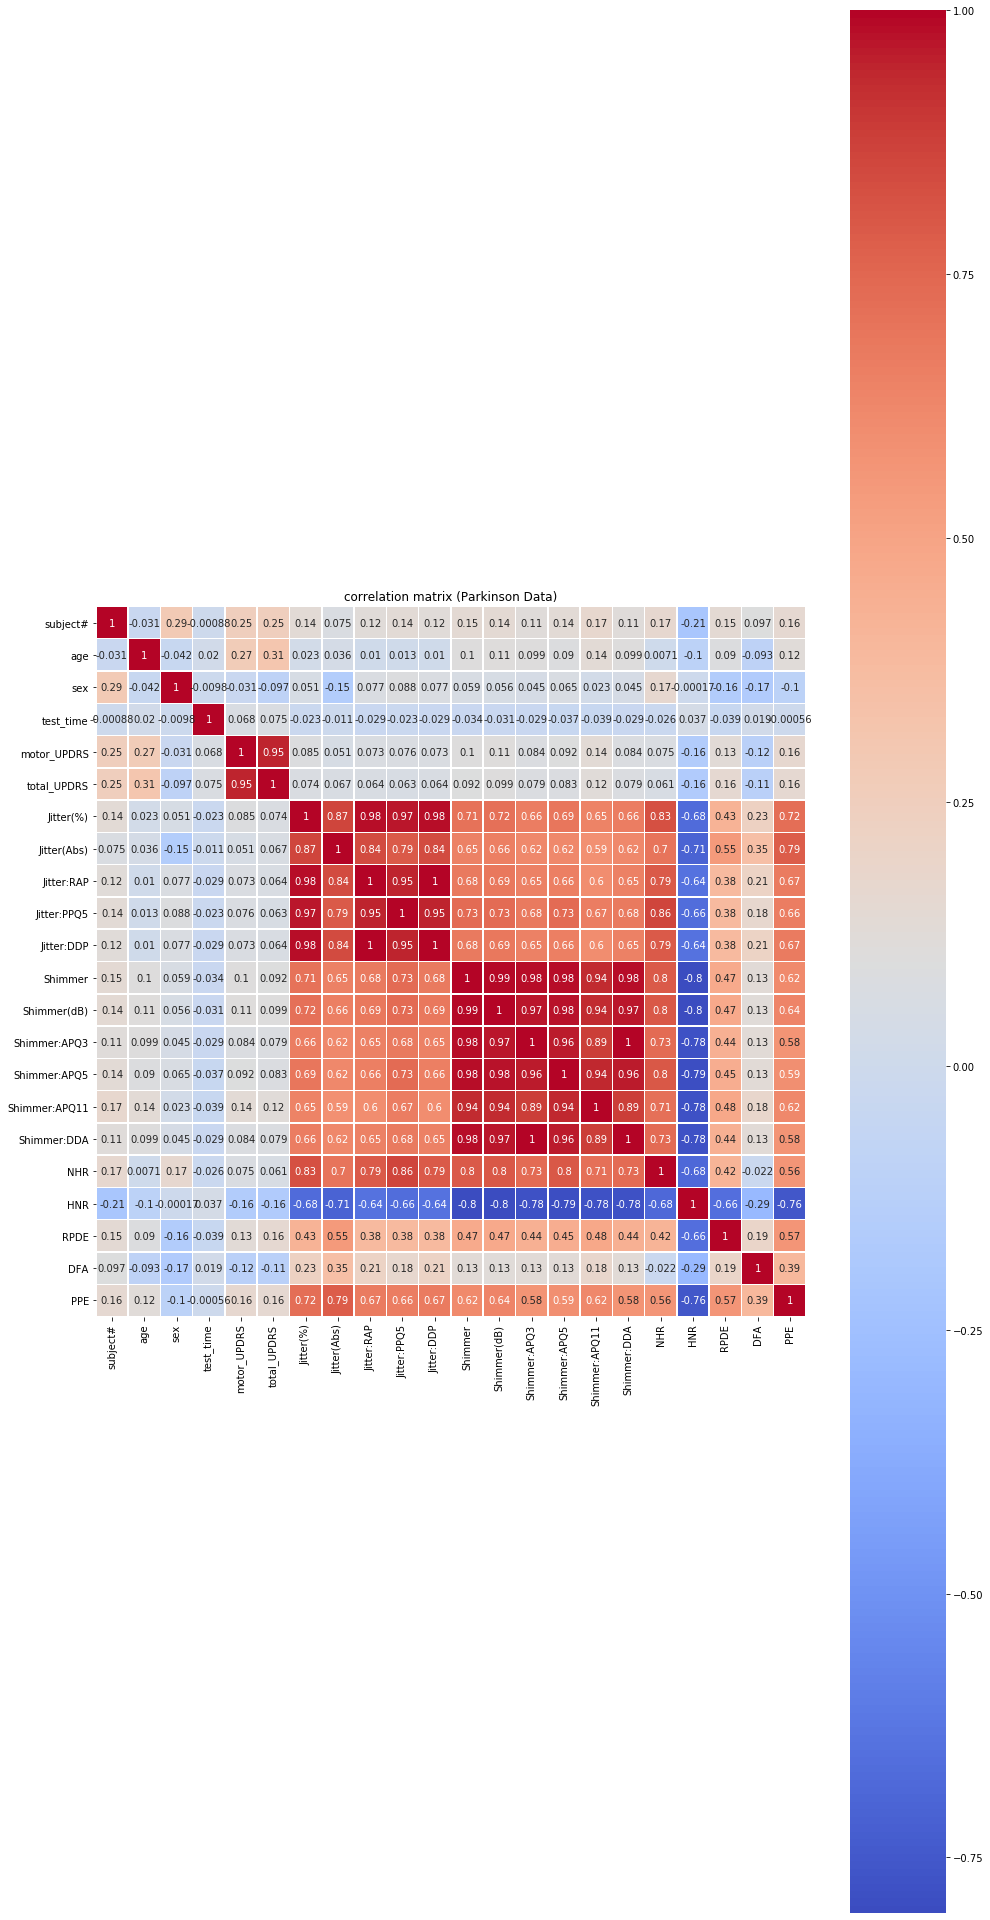

In [0]:
# make the correlation matrices.

corrmat_park = park_corr_df.corr()

# heatmaps are a great way to get 
# a quick visual read on a big correlation matrix.

plt.figure(figsize=(35,35))

plt.subplot(1,2,1)
# draw the heatmap using seaborn.
sns.heatmap(corrmat_park, square=True, cmap='coolwarm', annot=True, linewidths=.5)
plt.title("correlation matrix (Parkinson Data)")

plt.show()

# try to match the correlation numbers 
# to the scatterplots above to get a 
# sense of what each magnitude of 
# correlation can look like.



---
**UPDATED**

Based on the heatmap, We will keep one "Jitter" variable and one "Shimmer" because the rest are too colinear. NHR may have to go as well because it is highly correlated with Jitter%.


---




In [0]:
park['Shimmer'].describe()

count    5875.000000
mean        0.034035
std         0.025835
min         0.003060
25%         0.019120
50%         0.027510
75%         0.039750
max         0.268630
Name: Shimmer, dtype: float64

**UPDATED**
Here is start looking for outliers based on zscores. There are many outliers in this dataset it seems.

In [0]:
from scipy.stats import zscore

z_scores = zscore(park["NHR"])
for threshold in range(1,20):
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))


The score threshold is: 1
Number of outliers is: 274
The score threshold is: 2
Number of outliers is: 166
The score threshold is: 3
Number of outliers is: 112
The score threshold is: 4
Number of outliers is: 92
The score threshold is: 5
Number of outliers is: 67
The score threshold is: 6
Number of outliers is: 49
The score threshold is: 7
Number of outliers is: 31
The score threshold is: 8
Number of outliers is: 21
The score threshold is: 9
Number of outliers is: 13
The score threshold is: 10
Number of outliers is: 10
The score threshold is: 11
Number of outliers is: 7
The score threshold is: 12
Number of outliers is: 0
The score threshold is: 13
Number of outliers is: 0
The score threshold is: 14
Number of outliers is: 0
The score threshold is: 15
Number of outliers is: 0
The score threshold is: 16
Number of outliers is: 0
The score threshold is: 17
Number of outliers is: 0
The score threshold is: 18
Number of outliers is: 0
The score threshold is: 19
Number of outliers is: 0


In [0]:
from scipy.stats import zscore

z_scores = zscore(park["HNR"])
for threshold in range(1,8):
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))


The score threshold is: 1
Number of outliers is: 763
The score threshold is: 2
Number of outliers is: 79
The score threshold is: 3
Number of outliers is: 8
The score threshold is: 4
Number of outliers is: 0
The score threshold is: 5
Number of outliers is: 0
The score threshold is: 6
Number of outliers is: 0
The score threshold is: 7
Number of outliers is: 0


In [0]:
from scipy.stats import zscore

z_scores = zscore(park["RPDE"])
for threshold in range(1,15):
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))


The score threshold is: 1
Number of outliers is: 977
The score threshold is: 2
Number of outliers is: 81
The score threshold is: 3
Number of outliers is: 14
The score threshold is: 4
Number of outliers is: 2
The score threshold is: 5
Number of outliers is: 0
The score threshold is: 6
Number of outliers is: 0
The score threshold is: 7
Number of outliers is: 0
The score threshold is: 8
Number of outliers is: 0
The score threshold is: 9
Number of outliers is: 0
The score threshold is: 10
Number of outliers is: 0
The score threshold is: 11
Number of outliers is: 0
The score threshold is: 12
Number of outliers is: 0
The score threshold is: 13
Number of outliers is: 0
The score threshold is: 14
Number of outliers is: 0


In [0]:
from scipy.stats import zscore

z_scores = zscore(park["DFA"])
for threshold in range(1,15):
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))


The score threshold is: 1
Number of outliers is: 1190
The score threshold is: 2
Number of outliers is: 136
The score threshold is: 3
Number of outliers is: 0
The score threshold is: 4
Number of outliers is: 0
The score threshold is: 5
Number of outliers is: 0
The score threshold is: 6
Number of outliers is: 0
The score threshold is: 7
Number of outliers is: 0
The score threshold is: 8
Number of outliers is: 0
The score threshold is: 9
Number of outliers is: 0
The score threshold is: 10
Number of outliers is: 0
The score threshold is: 11
Number of outliers is: 0
The score threshold is: 12
Number of outliers is: 0
The score threshold is: 13
Number of outliers is: 0
The score threshold is: 14
Number of outliers is: 0


In [0]:
from scipy.stats import zscore

z_scores = zscore(park["PPE"])
for threshold in range(1,15):
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))


The score threshold is: 1
Number of outliers is: 836
The score threshold is: 2
Number of outliers is: 268
The score threshold is: 3
Number of outliers is: 75
The score threshold is: 4
Number of outliers is: 17
The score threshold is: 5
Number of outliers is: 4
The score threshold is: 6
Number of outliers is: 0
The score threshold is: 7
Number of outliers is: 0
The score threshold is: 8
Number of outliers is: 0
The score threshold is: 9
Number of outliers is: 0
The score threshold is: 10
Number of outliers is: 0
The score threshold is: 11
Number of outliers is: 0
The score threshold is: 12
Number of outliers is: 0
The score threshold is: 13
Number of outliers is: 0
The score threshold is: 14
Number of outliers is: 0


In [0]:
from scipy.stats import zscore

z_scores = zscore(park["Jitter(%)"])
for threshold in range(1,20):
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))


The score threshold is: 1
Number of outliers is: 388
The score threshold is: 2
Number of outliers is: 167
The score threshold is: 3
Number of outliers is: 107
The score threshold is: 4
Number of outliers is: 72
The score threshold is: 5
Number of outliers is: 49
The score threshold is: 6
Number of outliers is: 30
The score threshold is: 7
Number of outliers is: 17
The score threshold is: 8
Number of outliers is: 13
The score threshold is: 9
Number of outliers is: 10
The score threshold is: 10
Number of outliers is: 7
The score threshold is: 11
Number of outliers is: 6
The score threshold is: 12
Number of outliers is: 5
The score threshold is: 13
Number of outliers is: 5
The score threshold is: 14
Number of outliers is: 4
The score threshold is: 15
Number of outliers is: 2
The score threshold is: 16
Number of outliers is: 2
The score threshold is: 17
Number of outliers is: 0
The score threshold is: 18
Number of outliers is: 0
The score threshold is: 19
Number of outliers is: 0


In [0]:
from scipy.stats import zscore

z_scores = zscore(park["Jitter(Abs)"])
for threshold in range(1,20):
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))


The score threshold is: 1
Number of outliers is: 595
The score threshold is: 2
Number of outliers is: 243
The score threshold is: 3
Number of outliers is: 115
The score threshold is: 4
Number of outliers is: 61
The score threshold is: 5
Number of outliers is: 30
The score threshold is: 6
Number of outliers is: 16
The score threshold is: 7
Number of outliers is: 11
The score threshold is: 8
Number of outliers is: 7
The score threshold is: 9
Number of outliers is: 5
The score threshold is: 10
Number of outliers is: 1
The score threshold is: 11
Number of outliers is: 1
The score threshold is: 12
Number of outliers is: 0
The score threshold is: 13
Number of outliers is: 0
The score threshold is: 14
Number of outliers is: 0
The score threshold is: 15
Number of outliers is: 0
The score threshold is: 16
Number of outliers is: 0
The score threshold is: 17
Number of outliers is: 0
The score threshold is: 18
Number of outliers is: 0
The score threshold is: 19
Number of outliers is: 0


In [0]:
from scipy.stats import zscore

z_scores = zscore(park["Jitter:RAP"])
for threshold in range(1,20):
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))


The score threshold is: 1
Number of outliers is: 379
The score threshold is: 2
Number of outliers is: 170
The score threshold is: 3
Number of outliers is: 106
The score threshold is: 4
Number of outliers is: 71
The score threshold is: 5
Number of outliers is: 40
The score threshold is: 6
Number of outliers is: 29
The score threshold is: 7
Number of outliers is: 17
The score threshold is: 8
Number of outliers is: 15
The score threshold is: 9
Number of outliers is: 8
The score threshold is: 10
Number of outliers is: 8
The score threshold is: 11
Number of outliers is: 8
The score threshold is: 12
Number of outliers is: 6
The score threshold is: 13
Number of outliers is: 5
The score threshold is: 14
Number of outliers is: 4
The score threshold is: 15
Number of outliers is: 3
The score threshold is: 16
Number of outliers is: 3
The score threshold is: 17
Number of outliers is: 1
The score threshold is: 18
Number of outliers is: 0
The score threshold is: 19
Number of outliers is: 0


In [0]:
from scipy.stats import zscore

z_scores = zscore(park["Jitter:PPQ5"])
for threshold in range(1,20):
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))


The score threshold is: 1
Number of outliers is: 284
The score threshold is: 2
Number of outliers is: 137
The score threshold is: 3
Number of outliers is: 95
The score threshold is: 4
Number of outliers is: 75
The score threshold is: 5
Number of outliers is: 55
The score threshold is: 6
Number of outliers is: 41
The score threshold is: 7
Number of outliers is: 27
The score threshold is: 8
Number of outliers is: 18
The score threshold is: 9
Number of outliers is: 12
The score threshold is: 10
Number of outliers is: 10
The score threshold is: 11
Number of outliers is: 8
The score threshold is: 12
Number of outliers is: 6
The score threshold is: 13
Number of outliers is: 5
The score threshold is: 14
Number of outliers is: 4
The score threshold is: 15
Number of outliers is: 2
The score threshold is: 16
Number of outliers is: 1
The score threshold is: 17
Number of outliers is: 1
The score threshold is: 18
Number of outliers is: 0
The score threshold is: 19
Number of outliers is: 0


In [0]:
from scipy.stats import zscore

z_scores = zscore(park["Jitter:DDP"])
for threshold in range(1,20):
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))


The score threshold is: 1
Number of outliers is: 380
The score threshold is: 2
Number of outliers is: 170
The score threshold is: 3
Number of outliers is: 106
The score threshold is: 4
Number of outliers is: 71
The score threshold is: 5
Number of outliers is: 40
The score threshold is: 6
Number of outliers is: 29
The score threshold is: 7
Number of outliers is: 17
The score threshold is: 8
Number of outliers is: 15
The score threshold is: 9
Number of outliers is: 8
The score threshold is: 10
Number of outliers is: 8
The score threshold is: 11
Number of outliers is: 8
The score threshold is: 12
Number of outliers is: 6
The score threshold is: 13
Number of outliers is: 5
The score threshold is: 14
Number of outliers is: 4
The score threshold is: 15
Number of outliers is: 3
The score threshold is: 16
Number of outliers is: 3
The score threshold is: 17
Number of outliers is: 1
The score threshold is: 18
Number of outliers is: 0
The score threshold is: 19
Number of outliers is: 0


In [0]:
from scipy.stats import zscore

z_scores = zscore(park["Shimmer"])
for threshold in range(1,20):
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))


The score threshold is: 1
Number of outliers is: 506
The score threshold is: 2
Number of outliers is: 219
The score threshold is: 3
Number of outliers is: 142
The score threshold is: 4
Number of outliers is: 97
The score threshold is: 5
Number of outliers is: 55
The score threshold is: 6
Number of outliers is: 19
The score threshold is: 7
Number of outliers is: 6
The score threshold is: 8
Number of outliers is: 1
The score threshold is: 9
Number of outliers is: 1
The score threshold is: 10
Number of outliers is: 0
The score threshold is: 11
Number of outliers is: 0
The score threshold is: 12
Number of outliers is: 0
The score threshold is: 13
Number of outliers is: 0
The score threshold is: 14
Number of outliers is: 0
The score threshold is: 15
Number of outliers is: 0
The score threshold is: 16
Number of outliers is: 0
The score threshold is: 17
Number of outliers is: 0
The score threshold is: 18
Number of outliers is: 0
The score threshold is: 19
Number of outliers is: 0


In [0]:
from scipy.stats import zscore

z_scores = zscore(park["Shimmer"])
for threshold in range(1,20):
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))


The score threshold is: 1
Number of outliers is: 506
The score threshold is: 2
Number of outliers is: 219
The score threshold is: 3
Number of outliers is: 142
The score threshold is: 4
Number of outliers is: 97
The score threshold is: 5
Number of outliers is: 55
The score threshold is: 6
Number of outliers is: 19
The score threshold is: 7
Number of outliers is: 6
The score threshold is: 8
Number of outliers is: 1
The score threshold is: 9
Number of outliers is: 1
The score threshold is: 10
Number of outliers is: 0
The score threshold is: 11
Number of outliers is: 0
The score threshold is: 12
Number of outliers is: 0
The score threshold is: 13
Number of outliers is: 0
The score threshold is: 14
Number of outliers is: 0
The score threshold is: 15
Number of outliers is: 0
The score threshold is: 16
Number of outliers is: 0
The score threshold is: 17
Number of outliers is: 0
The score threshold is: 18
Number of outliers is: 0
The score threshold is: 19
Number of outliers is: 0


In [0]:
from scipy.stats import zscore

z_scores = zscore(park["Shimmer(dB)"])
for threshold in range(1,20):
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))


The score threshold is: 1
Number of outliers is: 519
The score threshold is: 2
Number of outliers is: 222
The score threshold is: 3
Number of outliers is: 144
The score threshold is: 4
Number of outliers is: 97
The score threshold is: 5
Number of outliers is: 53
The score threshold is: 6
Number of outliers is: 15
The score threshold is: 7
Number of outliers is: 3
The score threshold is: 8
Number of outliers is: 0
The score threshold is: 9
Number of outliers is: 0
The score threshold is: 10
Number of outliers is: 0
The score threshold is: 11
Number of outliers is: 0
The score threshold is: 12
Number of outliers is: 0
The score threshold is: 13
Number of outliers is: 0
The score threshold is: 14
Number of outliers is: 0
The score threshold is: 15
Number of outliers is: 0
The score threshold is: 16
Number of outliers is: 0
The score threshold is: 17
Number of outliers is: 0
The score threshold is: 18
Number of outliers is: 0
The score threshold is: 19
Number of outliers is: 0


In [0]:
from scipy.stats import zscore

z_scores = zscore(park["Shimmer:APQ3"])
for threshold in range(1,20):
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))


The score threshold is: 1
Number of outliers is: 566
The score threshold is: 2
Number of outliers is: 242
The score threshold is: 3
Number of outliers is: 136
The score threshold is: 4
Number of outliers is: 85
The score threshold is: 5
Number of outliers is: 42
The score threshold is: 6
Number of outliers is: 17
The score threshold is: 7
Number of outliers is: 4
The score threshold is: 8
Number of outliers is: 3
The score threshold is: 9
Number of outliers is: 2
The score threshold is: 10
Number of outliers is: 1
The score threshold is: 11
Number of outliers is: 0
The score threshold is: 12
Number of outliers is: 0
The score threshold is: 13
Number of outliers is: 0
The score threshold is: 14
Number of outliers is: 0
The score threshold is: 15
Number of outliers is: 0
The score threshold is: 16
Number of outliers is: 0
The score threshold is: 17
Number of outliers is: 0
The score threshold is: 18
Number of outliers is: 0
The score threshold is: 19
Number of outliers is: 0


In [0]:
from scipy.stats import zscore

z_scores = zscore(park["Shimmer:APQ5"])
for threshold in range(1,20):
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))


The score threshold is: 1
Number of outliers is: 478
The score threshold is: 2
Number of outliers is: 201
The score threshold is: 3
Number of outliers is: 139
The score threshold is: 4
Number of outliers is: 91
The score threshold is: 5
Number of outliers is: 58
The score threshold is: 6
Number of outliers is: 28
The score threshold is: 7
Number of outliers is: 15
The score threshold is: 8
Number of outliers is: 4
The score threshold is: 9
Number of outliers is: 0
The score threshold is: 10
Number of outliers is: 0
The score threshold is: 11
Number of outliers is: 0
The score threshold is: 12
Number of outliers is: 0
The score threshold is: 13
Number of outliers is: 0
The score threshold is: 14
Number of outliers is: 0
The score threshold is: 15
Number of outliers is: 0
The score threshold is: 16
Number of outliers is: 0
The score threshold is: 17
Number of outliers is: 0
The score threshold is: 18
Number of outliers is: 0
The score threshold is: 19
Number of outliers is: 0


In [0]:
from scipy.stats import zscore

z_scores = zscore(park["Shimmer:APQ11"])
for threshold in range(1,20):
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))


The score threshold is: 1
Number of outliers is: 545
The score threshold is: 2
Number of outliers is: 219
The score threshold is: 3
Number of outliers is: 134
The score threshold is: 4
Number of outliers is: 76
The score threshold is: 5
Number of outliers is: 40
The score threshold is: 6
Number of outliers is: 20
The score threshold is: 7
Number of outliers is: 10
The score threshold is: 8
Number of outliers is: 3
The score threshold is: 9
Number of outliers is: 2
The score threshold is: 10
Number of outliers is: 2
The score threshold is: 11
Number of outliers is: 1
The score threshold is: 12
Number of outliers is: 1
The score threshold is: 13
Number of outliers is: 0
The score threshold is: 14
Number of outliers is: 0
The score threshold is: 15
Number of outliers is: 0
The score threshold is: 16
Number of outliers is: 0
The score threshold is: 17
Number of outliers is: 0
The score threshold is: 18
Number of outliers is: 0
The score threshold is: 19
Number of outliers is: 0


In [0]:
from scipy.stats import zscore

z_scores = zscore(park["Shimmer:DDA"])
for threshold in range(1,20):
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))


The score threshold is: 1
Number of outliers is: 566
The score threshold is: 2
Number of outliers is: 241
The score threshold is: 3
Number of outliers is: 136
The score threshold is: 4
Number of outliers is: 85
The score threshold is: 5
Number of outliers is: 42
The score threshold is: 6
Number of outliers is: 17
The score threshold is: 7
Number of outliers is: 4
The score threshold is: 8
Number of outliers is: 3
The score threshold is: 9
Number of outliers is: 2
The score threshold is: 10
Number of outliers is: 1
The score threshold is: 11
Number of outliers is: 0
The score threshold is: 12
Number of outliers is: 0
The score threshold is: 13
Number of outliers is: 0
The score threshold is: 14
Number of outliers is: 0
The score threshold is: 15
Number of outliers is: 0
The score threshold is: 16
Number of outliers is: 0
The score threshold is: 17
Number of outliers is: 0
The score threshold is: 18
Number of outliers is: 0
The score threshold is: 19
Number of outliers is: 0


# Linear Regression

In [0]:
# Y is the target variable

Y = park['total_UPDRS']

# X is the feature set


X = park[['age', 'sex', 'test_time', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]


'''
X = park[['Jitter(%)','NHR', 'HNR', 'RPDE', 
          'DFA', 'PPE', 'Shimmer:APQ11']]
'''


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [0]:
# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("OLS model using sklearn")
print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


OLS model using sklearn
R-squared of the model in training set is: 0.18506621995063266
-----Test set statistics-----
R-squared of the model in test set is: 0.1367144740654198
Mean absolute error of the prediction is: 8.319379647535884
Mean squared error of the prediction is: 101.82546967809705
Root mean squared error of the prediction is: 10.090860700559544
Mean absolute percentage error of the prediction is: 37.07638715239275


In [0]:
lasso_cv = LassoCV(alphas=alphas, cv=25)
lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("LassoCV regression test")
print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

LassoCV regression test
Best alpha value is: 1e-06
R-squared of the model in training set is: 0.18496535116890367
-----Test set statistics-----
R-squared of the model in test set is: 0.13789295866050555
Mean absolute error of the prediction is: 8.319749772044892
Mean squared error of the prediction is: 101.68646613431228
Root mean squared error of the prediction is: 10.083970752353077
Mean absolute percentage error of the prediction is: 37.06481187812167


In [0]:
ridge_cv = RidgeCV(alphas=alphas, cv=25)
ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("RidgeCV() regression test")
print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

RidgeCV() regression test
Best alpha value is: 1e-07
R-squared of the model in training set is: 0.1849260816226993
-----Test set statistics-----
R-squared of the model in test set is: 0.1382673716446654
Mean absolute error of the prediction is: 8.318553381457495
Mean squared error of the prediction is: 101.64230371432456
Root mean squared error of the prediction is: 10.081780780909916
Mean absolute percentage error of the prediction is: 37.057743018036646


In [0]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=25)
ElasticNetCV()
elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("elasticnet_cv() regression test")
print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

elasticnet_cv() regression test
Best alpha value is: 1e-10
R-squared of the model in training set is: 0.1845518352679083
-----Test set statistics-----
R-squared of the model in test set is: 0.13952044401306163
Mean absolute error of the prediction is: 8.31652018340602
Mean squared error of the prediction is: 101.49450246129827
Root mean squared error of the prediction is: 10.074447997845752
Mean absolute percentage error of the prediction is: 37.03621907049604


In [0]:
park = parkinson.copy()

In [0]:
park["win_Jitter(%)"] = winsorized_views = winsorize(park["Jitter(%)"], (0.1, 0.1))
park["win_Jitter(Abs)"] = winsorized_views = winsorize(park["Jitter(Abs)"], (0.1, 0.1))
park["win_Jitter:RAP"] = winsorized_views = winsorize(park["Jitter:RAP"], (0.1, 0.1))
park["win_Jitter:PPQ5"] = winsorized_views = winsorize(park["Jitter:PPQ5"], (0.1, 0.1))
park["win_Jitter:DDP"] = winsorized_views = winsorize(park["Jitter:DDP"], (0.1, 0.1))
park["win_Shimmer"] = winsorized_views = winsorize(park["Shimmer"], (0.1, 0.1))
park["win_Shimmer(dB)"] = winsorized_views = winsorize(park["Shimmer(dB)"], (0.1, 0.1))
park["win_Shimmer:APQ3"] = winsorized_views = winsorize(park["Shimmer:APQ3"], (0.1, 0.1))
park["win_Shimmer:APQ5"] = winsorized_views = winsorize(park["Shimmer:APQ5"], (0.1, 0.1))
park["win_Shimmer:APQ11"] = winsorized_views = winsorize(park["Shimmer:APQ11"], (0.1, 0.1))
park["win_Shimmer:DDA"] = winsorized_views = winsorize(park["Shimmer:DDA"], (0.1, 0.1))

park["win_NHR"] = winsorized_views = winsorize(park["NHR"], (0.1, 0.1))
park["win_HNR"] = winsorized_views = winsorize(park["HNR"], (0.1, 0.1))
park["win_RPDE"] = winsorized_views = winsorize(park["RPDE"], (0.1, 0.1))
park["win_DFA"] = winsorized_views = winsorize(park["DFA"], (0.1, 0.1))
park["win_PPE"] = winsorized_views = winsorize(park["PPE"], (0.1, 0.1))

In [0]:
from scipy.stats import zscore

z_scores = zscore(park["win_Shimmer"])
for threshold in range(1,8):
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))


The score threshold is: 1
Number of outliers is: 1147
The score threshold is: 2
Number of outliers is: 0
The score threshold is: 3
Number of outliers is: 0
The score threshold is: 4
Number of outliers is: 0
The score threshold is: 5
Number of outliers is: 0
The score threshold is: 6
Number of outliers is: 0
The score threshold is: 7
Number of outliers is: 0


In [0]:
# Y is the target variable
Y = np.log1p(park['total_UPDRS'])
# X is the feature set



X = park[['age', 'sex', 'test_time', 'win_Jitter(%)', 'win_Jitter(Abs)', 'win_Jitter:RAP', 'win_Jitter:PPQ5', 
          'win_Jitter:DDP', 'win_Shimmer', 'win_Shimmer(dB)', 'win_Shimmer:APQ3', 'win_Shimmer:APQ5', 
          'win_NHR', 'win_HNR', 'win_RPDE', 'win_DFA', 'win_PPE', 'win_Shimmer:APQ11', 'win_Shimmer:DDA']]

'''
X = park[['age', 'sex', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]
'''        

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [0]:
# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("OLS model using sklearn")
print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


OLS model using sklearn
R-squared of the model in training set is: 0.2017471389841089
-----Test set statistics-----
R-squared of the model in test set is: 0.15700117739125086
Mean absolute error of the prediction is: 0.29542105959176074
Mean squared error of the prediction is: 0.13911527725742986
Root mean squared error of the prediction is: 0.37298160444910666
Mean absolute percentage error of the prediction is: 9.473319572603572


In [0]:
park = parkinson.copy()
park.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [0]:
park['subject#'].nunique()

42

In [0]:
park.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
subject#         5875 non-null int64
age              5875 non-null int64
sex              5875 non-null int64
test_time        5875 non-null float64
motor_UPDRS      5875 non-null float64
total_UPDRS      5875 non-null float64
Jitter(%)        5875 non-null float64
Jitter(Abs)      5875 non-null float64
Jitter:RAP       5875 non-null float64
Jitter:PPQ5      5875 non-null float64
Jitter:DDP       5875 non-null float64
Shimmer          5875 non-null float64
Shimmer(dB)      5875 non-null float64
Shimmer:APQ3     5875 non-null float64
Shimmer:APQ5     5875 non-null float64
Shimmer:APQ11    5875 non-null float64
Shimmer:DDA      5875 non-null float64
NHR              5875 non-null float64
HNR              5875 non-null float64
RPDE             5875 non-null float64
DFA              5875 non-null float64
PPE              5875 non-null float64
dtypes: float64(19), int64(3)
memory usag

In [0]:
# Y is the target variable
Y = np.log1p(park['total_UPDRS'])
# X is the feature set
'''
X = park[['Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]

'''


X = park[['age', 'sex', 'test_time', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [0]:
# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("OLS model using sklearn")
print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


OLS model using sklearn
R-squared of the model in training set is: 0.20861740993143263
-----Test set statistics-----
R-squared of the model in test set is: 0.15514478948547006
Mean absolute error of the prediction is: 0.29419608267965575
Mean squared error of the prediction is: 0.1394216263427238
Root mean squared error of the prediction is: 0.3733920544718698
Mean absolute percentage error of the prediction is: 9.434381643718083


In [0]:
# Y is the target variable
Y = np.log1p(park['total_UPDRS'])
# X is the feature set

X = park[['age', 'test_time', 'Shimmer(dB)', 'HNR', 'DFA']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [0]:
# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("OLS model using sklearn")
print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


OLS model using sklearn
R-squared of the model in training set is: 0.17420146642648338
-----Test set statistics-----
R-squared of the model in test set is: 0.15150762395472006
Mean absolute error of the prediction is: 0.298587622328992
Mean squared error of the prediction is: 0.14002184698084477
Root mean squared error of the prediction is: 0.37419493179470614
Mean absolute percentage error of the prediction is: 9.573305826031737




---



---



---

Random Forest Classifier

---



---



---



---




# Random Forest Classifier

In [0]:
park = parkinson.copy()

In [0]:
park.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
subject#         5875 non-null int64
age              5875 non-null int64
sex              5875 non-null int64
test_time        5875 non-null float64
motor_UPDRS      5875 non-null float64
total_UPDRS      5875 non-null float64
Jitter(%)        5875 non-null float64
Jitter(Abs)      5875 non-null float64
Jitter:RAP       5875 non-null float64
Jitter:PPQ5      5875 non-null float64
Jitter:DDP       5875 non-null float64
Shimmer          5875 non-null float64
Shimmer(dB)      5875 non-null float64
Shimmer:APQ3     5875 non-null float64
Shimmer:APQ5     5875 non-null float64
Shimmer:APQ11    5875 non-null float64
Shimmer:DDA      5875 non-null float64
NHR              5875 non-null float64
HNR              5875 non-null float64
RPDE             5875 non-null float64
DFA              5875 non-null float64
PPE              5875 non-null float64
dtypes: float64(19), int64(3)
memory usag

In [0]:
park.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [0]:
park['total_UPDRS'].describe()

count    5875.000000
mean       29.018942
std        10.700283
min         7.000000
25%        21.371000
50%        27.576000
75%        36.399000
max        54.992000
Name: total_UPDRS, dtype: float64

Now try to run a Random forest classifier on the dataset to see if is possible to detect various threshold on total_UPDRS every 4 points of total_UPDRS starting from 6 to 50.


In [0]:
park['tUPDRS_6'] = np.where(park['total_UPDRS'] > 6.0, 1,0)
park['tUPDRS_10'] = np.where(park['total_UPDRS'] > 10.0, 1,0)
park['tUPDRS_14'] = np.where(park['total_UPDRS'] > 14.0, 1,0)
park['tUPDRS_18'] = np.where(park['total_UPDRS'] > 18.0, 1,0)
park['tUPDRS_22'] = np.where(park['total_UPDRS'] > 22.0, 1,0)
park['tUPDRS_26'] = np.where(park['total_UPDRS'] > 26.0, 1,0)
park['tUPDRS_30'] = np.where(park['total_UPDRS'] > 30.0, 1,0)
park['tUPDRS_34'] = np.where(park['total_UPDRS'] > 34.0, 1,0)
park['tUPDRS_38'] = np.where(park['total_UPDRS'] > 38.0, 1,0)
park['tUPDRS_42'] = np.where(park['total_UPDRS'] > 42.0, 1,0)
park['tUPDRS_46'] = np.where(park['total_UPDRS'] > 46.0, 1,0)
park['tUPDRS_50'] = np.where(park['total_UPDRS'] > 50.0, 1,0)



In [0]:
park.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,tUPDRS_6,tUPDRS_10,tUPDRS_14,tUPDRS_18,tUPDRS_22,tUPDRS_26,tUPDRS_30,tUPDRS_34,tUPDRS_38,tUPDRS_42,tUPDRS_46,tUPDRS_50
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006,1,1,1,1,1,1,1,1,0,0,0,0
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810,1,1,1,1,1,1,1,1,0,0,0,0
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014,1,1,1,1,1,1,1,1,0,0,0,0
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277,1,1,1,1,1,1,1,1,0,0,0,0
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361,1,1,1,1,1,1,1,1,0,0,0,0


In [0]:
park['tUPDRS_42'].describe()

count    5875.000000
mean        0.133277
std         0.339902
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: tUPDRS_42, dtype: float64

In [0]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()

#X = bcdata.drop('diagnosis', 1)

X = park[['age', 'sex', 'test_time', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]


X = pd.get_dummies(X)
X = X.dropna(axis=1)

Y = park['tUPDRS_10']
print("tUPDRS > 10")
print(cross_val_score(rfc, X, Y, cv=5))



tUPDRS > 10
[0.9693617  0.95914894 0.94893617 0.90468085 0.96680851]


In [0]:
Y = park['tUPDRS_14']
print("tUPDRS > 14")
print(cross_val_score(rfc, X, Y, cv=5))

Y = park['tUPDRS_18']
print("tUPDRS > 18")
print(cross_val_score(rfc, X, Y, cv=5))


tUPDRS > 14
[0.93787234 0.91234043 0.97191489 0.92340426 0.93787234]
tUPDRS > 18
[0.85021277 0.81531915 0.74638298 0.88340426 0.84      ]


In [0]:
Y = park['tUPDRS_22']
print("tUPDRS > 22")
print(cross_val_score(rfc, X, Y, cv=5))

Y = park['tUPDRS_26']
print("tUPDRS > 26")
print(cross_val_score(rfc, X, Y, cv=5))


tUPDRS > 22
[0.73531915 0.7787234  0.69787234 0.74978723 0.62468085]
tUPDRS > 26
[0.50382979 0.36       0.51914894 0.65191489 0.5012766 ]


In [0]:
Y = park['tUPDRS_30']
print("tUPDRS > 30")
print(cross_val_score(rfc, X, Y, cv=5))

Y = park['tUPDRS_34']
print("tUPDRS > 34")
print(cross_val_score(rfc, X, Y, cv=5))


tUPDRS > 30
[0.46297872 0.49702128 0.25787234 0.63574468 0.26212766]
tUPDRS > 34
[0.52       0.60510638 0.69276596 0.40255319 0.61617021]


In [0]:
Y = park['tUPDRS_38']
print("tUPDRS > 38")
print(cross_val_score(rfc, X, Y, cv=5))

Y = park['tUPDRS_42']
print("tUPDRS > 42")
print(cross_val_score(rfc, X, Y, cv=5))


tUPDRS > 38
[0.62553191 0.78212766 0.74638298 0.35659574 0.77106383]
tUPDRS > 42
[0.79829787 0.85702128 0.92851064 0.73957447 0.86638298]


In [0]:
Y = park['tUPDRS_46']
print("tUPDRS > 46")
print(cross_val_score(rfc, X, Y, cv=5))

Y = park['tUPDRS_50']
print("tUPDRS > 50")
print(cross_val_score(rfc, X, Y, cv=5))


tUPDRS > 46
[0.88       0.94808511 0.98553191 0.8706383  0.96851064]
tUPDRS > 50
[0.96170213 0.99404255 0.99829787 0.98638298 0.99234043]


In [0]:
dum_park = pd.get_dummies(park, drop_first=True)
dum_park.shape

(5875, 34)

In [0]:
dum_park.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,tUPDRS_6,tUPDRS_10,tUPDRS_14,tUPDRS_18,tUPDRS_22,tUPDRS_26,tUPDRS_30,tUPDRS_34,tUPDRS_38,tUPDRS_42,tUPDRS_46,tUPDRS_50
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006,1,1,1,1,1,1,1,1,0,0,0,0
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810,1,1,1,1,1,1,1,1,0,0,0,0
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014,1,1,1,1,1,1,1,1,0,0,0,0
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277,1,1,1,1,1,1,1,1,0,0,0,0
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361,1,1,1,1,1,1,1,1,0,0,0,0


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = dum_park[['age', 'sex', 'test_time', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]

y = dum_park['tUPDRS_30']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.1)

rf = RandomForestClassifier(max_depth=10)

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

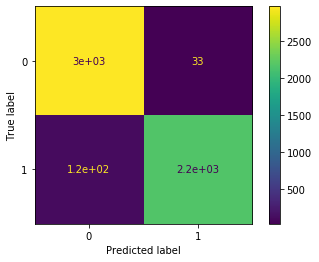

In [0]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(rf, X_train, y_train)

In [0]:
from sklearn.model_selection import GridSearchCV
import math
param_grid = {'max_depth': [4,8,16], 'max_features': [int(math.sqrt(len(X.columns))), int(math.log(len(X.columns)))]}
gs = GridSearchCV(rf, param_grid=param_grid)
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)


0.9247209618834201
{'max_depth': 16, 'max_features': 4}


0.9404761904761905


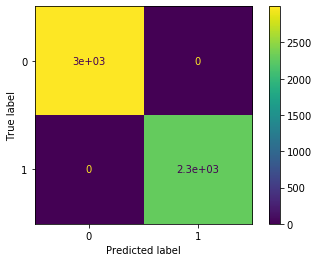

In [0]:

X = dum_park[['age', 'sex', 'test_time', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]


y = dum_park['tUPDRS_30']

rf = RandomForestClassifier(max_depth=gs.best_params_['max_depth'], max_features=gs.best_params_['max_features'])
rf.fit(X_train, y_train)

print(rf.score(X_test, y_test))
plot_confusion_matrix(rf, X_train, y_train)



---



---
Feature Importance


---



---



# Feature Selection

In [0]:
park = parkinson.copy()



---



---

LASSO Feature Selection


---



---



In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier


# Y is the target variable

Y = park['total_UPDRS']

# X is the feature set

X = park[['age', 'test_time', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 465)


In [0]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

# We use the base estimator LassoCV
clf = LassoCV(cv=100)

# Set a minimum threshold of 0.01
sfm = SelectFromModel(clf, threshold=0.01)
sfm.fit(X, Y)
n_features = sfm.transform(X).shape[1]

# Extracting the index of important features
feature_idx = sfm.get_support()

# Using the index to print the names of the important variables

print(X.columns[feature_idx])

Index(['age', 'test_time', 'Shimmer(dB)', 'HNR', 'DFA'], dtype='object')




---



---

Random Forest Classifier Feature Selection

---



---



In [0]:
park['tUPDRS_34'] = np.where(park['total_UPDRS'] > 34.0, 1,0)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier


# Y is the target variable

Y = park['tUPDRS_34']

# X is the feature set

X = park[['age', 'test_time', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 465)


In [0]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)
sel.get_support()
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)
print(selected_feat)

Index(['age', 'test_time', 'Jitter(Abs)', 'DFA'], dtype='object')




---



---

Gradient Boosting Classifier Feature Selection

---



---



In [0]:
park['tUPDRS_34'] = np.where(park['total_UPDRS'] > 34.0, 1,0)

In [0]:
from sklearn.model_selection import train_test_split

# Y is the target variable

Y = park['tUPDRS_34']

# X is the feature set

X = park[['age', 'test_time', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


In [0]:
params = {'n_estimators': 100, 'max_depth': 2, 'loss': 'deviance'}
              # Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)

clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

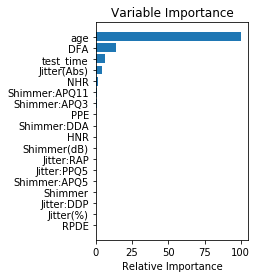

In [0]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()



---



---


Gradient Boosting Regressor Feature Selection

---



---



In [0]:
# Y is the target variable

Y = park['total_UPDRS']

# X is the feature set

X = park[['age', 'test_time', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


In [0]:
params = {'n_estimators': 100, 'max_depth': 2}
              # Initialize and fit the model.

clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

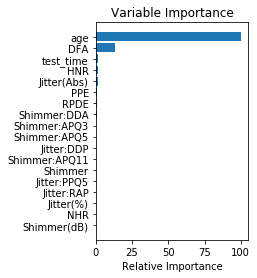

In [0]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# 3d graph

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

column_names=["X","Y","Z"]
df = pd.DataFrame(columns = column_names)

df['Y'] =  park['DFA']*100
df['X'] =  park['Jitter(Abs)']*100000
df['Z'] =  park['total_UPDRS']


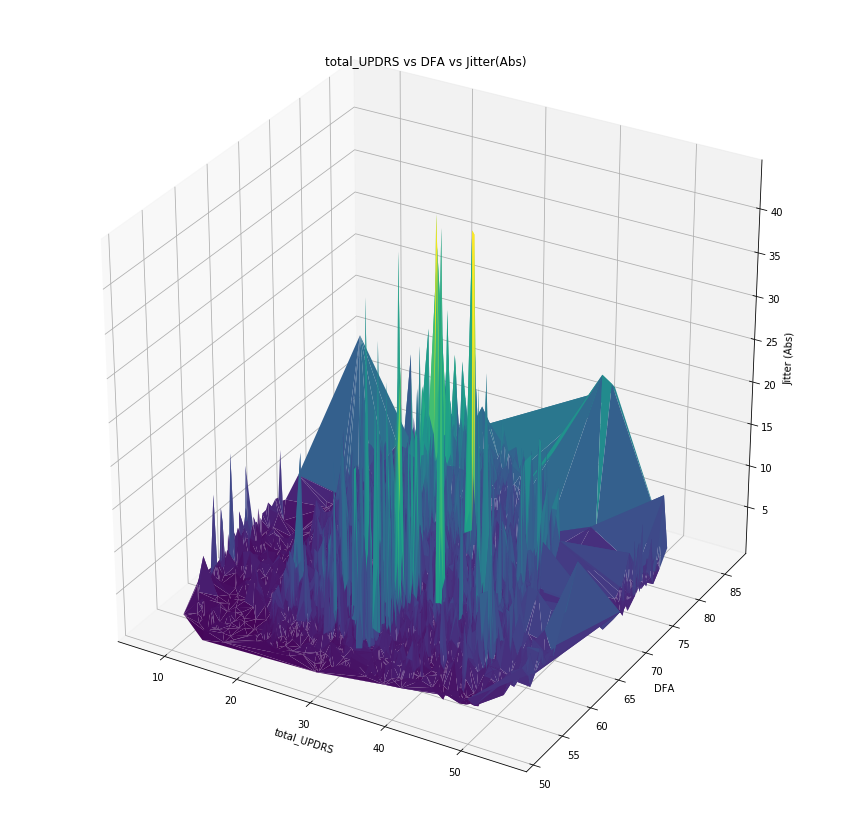

In [0]:
# Make the plot
fig = plt.figure(figsize=(15.0,15.0))
ax = fig.gca(projection='3d',xlabel='total_UPDRS',zlabel='Jitter (Abs)', ylabel='DFA',title='total_UPDRS vs DFA vs Jitter(Abs)')

ax.plot_trisurf(df['Z'], df['Y'], df['X'], cmap=plt.cm.viridis, linewidth=0.2)
plt.show()
 
# to Add a color bar which maps values to colors.

surf=ax.plot_trisurf(df['Z'], df['Y'], df['X'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)
plt.show()
 
# Rotate it
ax.view_init(45, 60)

plt.show()
 
# Other palette

ax.plot_trisurf(df['Z'], df['Y'], df['X'], cmap=plt.cm.jet, linewidth=0.01)

plt.show()





---



---


The project I am proposing for my supervised learning capstone is based on this 
dataset posted on UC Irvine. The idea is to predict total_updrs (A measure of the progression of Parkinsons disease) based on voice recordings sent from a group of Parkinsons patients to the adminstrators of the trial. This was done within a 6 month study. There were 42 patients in this clinical study and they made 5,875 voice recordings each recording represented by one row in this dataset. There are about 140 voice recordings made per patient.





[Parkinsons Telemonitoring Data Set UC Irvine](http://archive.ics.uci.edu/ml/datasets/Parkinsons+Telemonitoring)


[Kaggle link for Parkinsons Telemonitoring dataset](https://www.kaggle.com/mountainguest/parkinsons-telemonitoring)

This notebook contains the iterations of Random Forest Regressor ran on this dataset. Slightly but significantly better results were observed by splitting the dataset into male and female patients.



---


---

It seems it is possible to predict the porgression of the UPDRS rating of a parkinsons patient based on voice recordings made over a 6 month time period. Perhaps these findings will have implications for devleoping systems that can detect the early onset of Parkinsons just by analyzing a patients voice.


---



---






---


Start again with a fresh copy of the dataset.



---



In [0]:
park = parkinson.copy()
park.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
subject#         5875 non-null int64
age              5875 non-null int64
sex              5875 non-null int64
test_time        5875 non-null float64
motor_UPDRS      5875 non-null float64
total_UPDRS      5875 non-null float64
Jitter(%)        5875 non-null float64
Jitter(Abs)      5875 non-null float64
Jitter:RAP       5875 non-null float64
Jitter:PPQ5      5875 non-null float64
Jitter:DDP       5875 non-null float64
Shimmer          5875 non-null float64
Shimmer(dB)      5875 non-null float64
Shimmer:APQ3     5875 non-null float64
Shimmer:APQ5     5875 non-null float64
Shimmer:APQ11    5875 non-null float64
Shimmer:DDA      5875 non-null float64
NHR              5875 non-null float64
HNR              5875 non-null float64
RPDE             5875 non-null float64
DFA              5875 non-null float64
PPE              5875 non-null float64
dtypes: float64(19), int64(3)
memory usag



---


2. Do data cleaning, exploratory data analysis, and feature engineering. 


---




In [0]:
dtale_app.USE_NGROK = True
dtale.show(park, ignore_duplicate=True)


http://71690c6e.ngrok.io/dtale/main/2

In [0]:
park.isnull().sum()*100/park.isnull().count()

subject#         0.0
age              0.0
sex              0.0
test_time        0.0
motor_UPDRS      0.0
total_UPDRS      0.0
Jitter(%)        0.0
Jitter(Abs)      0.0
Jitter:RAP       0.0
Jitter:PPQ5      0.0
Jitter:DDP       0.0
Shimmer          0.0
Shimmer(dB)      0.0
Shimmer:APQ3     0.0
Shimmer:APQ5     0.0
Shimmer:APQ11    0.0
Shimmer:DDA      0.0
NHR              0.0
HNR              0.0
RPDE             0.0
DFA              0.0
PPE              0.0
dtype: float64


---


Just doing some EDA on a few variables.

---



In [0]:
park['sex'].nunique()

2

In [0]:
park['sex'].unique()

array([0, 1])

In [0]:
park['age'].unique()

array([72, 58, 57, 74, 75, 63, 73, 68, 55, 62, 65, 66, 67, 59, 60, 76, 49,
       78, 36, 71, 56, 85, 61])

In [0]:
park['test_time'].nunique()

2442




---


---


Split the dataset into Male and Female to create a model for each group of patients separately.

---


---




In [0]:
park_F = park[park['sex']== 1]
park_M = park[park['sex']== 0]

In [0]:
park_M.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [0]:
park_M.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4008 entries, 0 to 5874
Data columns (total 22 columns):
subject#         4008 non-null int64
age              4008 non-null int64
sex              4008 non-null int64
test_time        4008 non-null float64
motor_UPDRS      4008 non-null float64
total_UPDRS      4008 non-null float64
Jitter(%)        4008 non-null float64
Jitter(Abs)      4008 non-null float64
Jitter:RAP       4008 non-null float64
Jitter:PPQ5      4008 non-null float64
Jitter:DDP       4008 non-null float64
Shimmer          4008 non-null float64
Shimmer(dB)      4008 non-null float64
Shimmer:APQ3     4008 non-null float64
Shimmer:APQ5     4008 non-null float64
Shimmer:APQ11    4008 non-null float64
Shimmer:DDA      4008 non-null float64
NHR              4008 non-null float64
HNR              4008 non-null float64
RPDE             4008 non-null float64
DFA              4008 non-null float64
PPE              4008 non-null float64
dtypes: float64(19), int64(3)
memory usag

In [0]:
park_F.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
1048,8,73,1,8.5951,18.093,24.093,0.00508,0.000027,0.00268,0.00279,0.00805,0.04755,0.424,0.02559,0.02831,0.03348,0.07678,0.025365,19.363,0.64008,0.70365,0.20803
1049,8,73,1,15.5480,18.169,24.169,0.00870,0.000047,0.00462,0.00441,0.01387,0.04736,0.449,0.02690,0.02956,0.03270,0.08071,0.046591,19.606,0.56726,0.72053,0.18637
1050,8,73,1,22.5930,18.246,24.246,0.00540,0.000031,0.00229,0.00260,0.00688,0.03349,0.306,0.01739,0.01957,0.02737,0.05217,0.028065,19.002,0.63515,0.71451,0.27613
1051,8,73,1,29.5960,18.322,24.322,0.00425,0.000024,0.00218,0.00229,0.00655,0.04701,0.413,0.02552,0.02877,0.03572,0.07656,0.019043,18.876,0.56773,0.71409,0.19190
1052,8,73,1,36.5670,18.397,24.397,0.00360,0.000020,0.00152,0.00168,0.00457,0.03480,0.319,0.01818,0.02006,0.02664,0.05454,0.015952,21.696,0.57401,0.67361,0.20149


In [0]:
park_F.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1867 entries, 1048 to 5724
Data columns (total 22 columns):
subject#         1867 non-null int64
age              1867 non-null int64
sex              1867 non-null int64
test_time        1867 non-null float64
motor_UPDRS      1867 non-null float64
total_UPDRS      1867 non-null float64
Jitter(%)        1867 non-null float64
Jitter(Abs)      1867 non-null float64
Jitter:RAP       1867 non-null float64
Jitter:PPQ5      1867 non-null float64
Jitter:DDP       1867 non-null float64
Shimmer          1867 non-null float64
Shimmer(dB)      1867 non-null float64
Shimmer:APQ3     1867 non-null float64
Shimmer:APQ5     1867 non-null float64
Shimmer:APQ11    1867 non-null float64
Shimmer:DDA      1867 non-null float64
NHR              1867 non-null float64
HNR              1867 non-null float64
RPDE             1867 non-null float64
DFA              1867 non-null float64
PPE              1867 non-null float64
dtypes: float64(19), int64(3)
memory u

In [0]:
park_M['subject#'].nunique()

28

In [0]:
park_F['subject#'].nunique()

14



---



---



---

Run the model on all patients Male and Female

---



---



---



---



# Random Forest Regressor

In [0]:
from sklearn.model_selection import train_test_split

# Y is the target variable

Y = park['total_UPDRS']

# X is the feature set

X = park[['age', 'test_time', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


In [0]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 500, random_state = 666, min_samples_leaf=2, max_depth=16)
regressor.fit(X_train, y_train)

# We are making predictions here
y_preds_train = regressor.predict(X_train)
y_preds_test = regressor.predict(X_test)

In [0]:
print("RandomForestRegressor model using sklearn")
print("R-squared of the model in training set is: {}".format(regressor.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(regressor.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


RandomForestRegressor model using sklearn
R-squared of the model in training set is: 0.987387117640839
-----Test set statistics-----
R-squared of the model in test set is: 0.9473602586260563
Mean absolute error of the prediction is: 1.2631222633078498
Mean squared error of the prediction is: 6.208914928039166
Root mean squared error of the prediction is: 2.4917694371749497
Mean absolute percentage error of the prediction is: 6.426107734024068


In [0]:
rfr = RandomForestRegressor(n_estimators = 500, random_state = 456, min_samples_leaf=2, max_depth=16)

cross_val = cross_val_score(rfr, X_train, y_train, cv=10) 

print("Results of cross_val_score")
print(cross_val)
print("The mean of cross_val_score ", cross_val.mean())
print("The  std of cross_val_score ", cross_val.std())

Results of cross_val_score
[0.93663607 0.94725171 0.96514131 0.94578673 0.93415359 0.94159819
 0.93794742 0.92520089 0.92038742 0.92745391]
The mean of cross_val_score  0.9381557255959315
The  std of cross_val_score  0.012237159995851109


In [0]:
# Y is the target variable

Y = park['total_UPDRS']

# X is the feature set

#Results from RF feature selection
 #Index(['age', 'test_time', 'Jitter(Abs)', 'DFA'], dtype='object')


X = park[['age', 'test_time', 'Jitter(Abs)', 'DFA']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


In [0]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 500, random_state = 666, min_samples_leaf=2, max_depth=16)
regressor.fit(X_train, y_train)

# We are making predictions here
y_preds_train = regressor.predict(X_train)
y_preds_test = regressor.predict(X_test)

In [0]:
print("RandomForestRegressor model using sklearn")
print("R-squared of the model in training set is: {}".format(regressor.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(regressor.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


RandomForestRegressor model using sklearn
R-squared of the model in training set is: 0.9800672100660405
-----Test set statistics-----
R-squared of the model in test set is: 0.9366054710389222
Mean absolute error of the prediction is: 1.238280927452337
Mean squared error of the prediction is: 7.477453858032884
Root mean squared error of the prediction is: 2.7344933457649674
Mean absolute percentage error of the prediction is: 5.641020073628175


In [0]:
rfr = RandomForestRegressor(n_estimators = 500, random_state = 456, min_samples_leaf=2, max_depth=16)

cross_val = cross_val_score(rfr, X_train, y_train, cv=10) 

print("Results of cross_val_score")
print(cross_val)
print("The mean of cross_val_score ", cross_val.mean())
print("The  std of cross_val_score ", cross_val.std())

Results of cross_val_score
[0.93015274 0.93199239 0.9557143  0.93638683 0.91695881 0.91218852
 0.94437401 0.90940466 0.91860188 0.89953337]
The mean of cross_val_score  0.925530751003326
The  std of cross_val_score  0.016378347018497625


In [5]:
park.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
subject#         5875 non-null int64
age              5875 non-null int64
sex              5875 non-null int64
test_time        5875 non-null float64
motor_UPDRS      5875 non-null float64
total_UPDRS      5875 non-null float64
Jitter(%)        5875 non-null float64
Jitter(Abs)      5875 non-null float64
Jitter:RAP       5875 non-null float64
Jitter:PPQ5      5875 non-null float64
Jitter:DDP       5875 non-null float64
Shimmer          5875 non-null float64
Shimmer(dB)      5875 non-null float64
Shimmer:APQ3     5875 non-null float64
Shimmer:APQ5     5875 non-null float64
Shimmer:APQ11    5875 non-null float64
Shimmer:DDA      5875 non-null float64
NHR              5875 non-null float64
HNR              5875 non-null float64
RPDE             5875 non-null float64
DFA              5875 non-null float64
PPE              5875 non-null float64
dtypes: float64(19), int64(3)
memory usag

In [0]:
from sklearn.model_selection import train_test_split

# Y is the target variable

Y = park['age']

# X is the feature set


X = park[['test_time', 'total_UPDRS', 'motor_UPDRS', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]

'''
X = park[['test_time', 'total_UPDRS', 'Jitter(Abs)', 
          'Shimmer(dB)', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']]
'''

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


In [0]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 500, random_state = 666, min_samples_leaf=2, max_depth=16)
regressor.fit(X_train, y_train)

# We are making predictions here
y_preds_train = regressor.predict(X_train)
y_preds_test = regressor.predict(X_test)

In [23]:
print("RandomForestRegressor model using sklearn")
print("R-squared of the model in training set is: {}".format(regressor.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(regressor.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


RandomForestRegressor model using sklearn
R-squared of the model in training set is: 0.9573765071682752
-----Test set statistics-----
R-squared of the model in test set is: 0.8097208988718406
Mean absolute error of the prediction is: 2.474285667037368
Mean squared error of the prediction is: 15.486108364504357
Root mean squared error of the prediction is: 3.93523930206339
Mean absolute percentage error of the prediction is: 4.046176620248538


In [0]:
rfr = RandomForestRegressor(n_estimators = 500, random_state = 456, min_samples_leaf=2, max_depth=16)

cross_val = cross_val_score(rfr, X_train, y_train, cv=10) 

print("Results of cross_val_score")
print(cross_val)
print("The mean of cross_val_score ", cross_val.mean())
print("The  std of cross_val_score ", cross_val.std())

Results of cross_val_score
[0.28936969 0.37546177 0.40429197 0.35352359 0.36564476 0.34887275
 0.33529728 0.38493009 0.34714785 0.36219037]
The mean of cross_val_score  0.35667301143323404
The  std of cross_val_score  0.029458666088983877




---



---



---


XGBRegressor


---



---



---



In [1]:
park = parkinson.copy()
park.head(5)

NameError: ignored

In [0]:
park_F = park[park['sex']== 1]
park_M = park[park['sex']== 0]

In [0]:
from sklearn.model_selection import train_test_split

# Y is the target variable

Y = park['total_UPDRS']

# X is the feature set

X = park[['age', 'test_time', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 6665)


In [0]:
from xgboost import XGBRegressor

xgb = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=500, verbosity=0)

xgb.fit(X_train, y_train)

# We are making predictions here
y_preds_train = xgb.predict(X_train)
y_preds_test = xgb.predict(X_test)

In [0]:
print("XGBRegressor model")
print("R-squared of the model in training set is: {}".format(xgb.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(xgb.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


XGBRegressor model
R-squared of the model in training set is: 0.9935469388503028
-----Test set statistics-----
R-squared of the model in test set is: 0.9350463940577703
Mean absolute error of the prediction is: 1.785514435691671
Mean squared error of the prediction is: 7.185800973571079
Root mean squared error of the prediction is: 2.680634434899895
Mean absolute percentage error of the prediction is: 7.56178034870612


In [0]:
xgb = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=500, verbosity=0)

cross_val = cross_val_score(xgb, X_train, y_train, cv=10) 

print("Results of cross_val_score")
print(cross_val)
print("The mean of cross_val_score ", cross_val.mean())
print("The  std of cross_val_score ", cross_val.std())

Results of cross_val_score
[0.93153599 0.94116035 0.94119595 0.93289438 0.93709203 0.94570047
 0.95173475 0.94573312 0.94639362 0.92247486]
The mean of cross_val_score  0.9395915510935927
The  std of cross_val_score  0.008262997679916036




---



---



---
Run the model on the Female Data Set


---



---



---



# Female Model  -  RF and XGB Regressors

In [0]:
from sklearn.model_selection import train_test_split

# Y is the target variable

Y = park_F['total_UPDRS']

# X is the feature set

X = park_F[['age', 'test_time', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


In [0]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 500, random_state = 666, min_samples_leaf=2, max_depth=16)
regressor.fit(X_train, y_train)

# We are making predictions here
y_preds_train = regressor.predict(X_train)
y_preds_test = regressor.predict(X_test)

In [0]:
print("RandomForestRegressor model using sklearn")
print("R-squared of the model in training set is: {}".format(regressor.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(regressor.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


RandomForestRegressor model using sklearn
R-squared of the model in training set is: 0.9979546493927285
-----Test set statistics-----
R-squared of the model in test set is: 0.9925886663459298
Mean absolute error of the prediction is: 0.4073523962941771
Mean squared error of the prediction is: 0.71798946599372
Root mean squared error of the prediction is: 0.8473425906879224
Mean absolute percentage error of the prediction is: 1.7739860257089597


In [0]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfr = ensemble.RandomForestRegressor()

cross_val = cross_val_score(rfr, X_train, y_train, cv=10) 

print("Results of cross_val_score")
print(cross_val)
print("The mean of cross_val_score ", cross_val.mean())
print("The  std of cross_val_score ", cross_val.std())

Results of cross_val_score
[0.98965319 0.98177388 0.99477178 0.9942397  0.9879706  0.98946516
 0.99456352 0.99444622 0.99361819 0.98877971]
The mean of cross_val_score  0.9909281942921371
The  std of cross_val_score  0.003993723963905185


In [0]:
rfr = ensemble.RandomForestRegressor(n_estimators = 500, random_state = 666, min_samples_leaf=2, max_depth=16)

cross_val = cross_val_score(rfr, X_train, y_train, cv=10) 

print("Results of cross_val_score")
print(cross_val)
print("The mean of cross_val_score ", cross_val.mean())
print("The  std of cross_val_score ", cross_val.std())

Results of cross_val_score
[0.98832425 0.97907625 0.99373963 0.99438315 0.98945259 0.98786548
 0.99468361 0.99171081 0.99260916 0.98650017]
The mean of cross_val_score  0.9898345089854409
The  std of cross_val_score  0.004514806100008114


In [0]:
from sklearn.model_selection import GridSearchCV

crfr = GridSearchCV(rfr, param_grid={'n_estimators': [1, 10, 100, 1000], 'min_samples_leaf':[ 1, 2, 4], 'max_depth':[ 4, 8, 16, 32]})
crfr.fit(X_train, y_train)

print(crfr.best_params_)
print(crfr.best_score_)


{'max_depth': 32, 'min_samples_leaf': 1, 'n_estimators': 100}
0.9893880498013781


In [0]:
rfr = RandomForestRegressor(n_estimators = 100, random_state = 456, min_samples_leaf=1, max_depth=32)

cross_val = cross_val_score(rfr, X_train, y_train, cv=10) 

print("Results of cross_val_score")
print(cross_val)
print("The mean of cross_val_score ", cross_val.mean())
print("The  std of cross_val_score ", cross_val.std())

Results of cross_val_score
[0.98896942 0.9836622  0.99503939 0.99463774 0.99090614 0.98946377
 0.99451168 0.99365241 0.99381692 0.98699644]
The mean of cross_val_score  0.9911656106379176
The  std of cross_val_score  0.0036461167976021805


In [0]:
rfr = RandomForestRegressor(n_estimators = 100, random_state = 456, min_samples_leaf=1)

crfr = GridSearchCV(rfr, param_grid={'max_depth': [12, 16, 20, 32, 40, 48]})
crfr.fit(X_train, y_train)

print(crfr.best_params_)
print(crfr.best_score_)


{'max_depth': 16}
0.9890851198896382


In [0]:
rfr = RandomForestRegressor(n_estimators = 100, max_features = 16, random_state = 456, min_samples_leaf=1, max_depth=16)

cross_val = cross_val_score(rfr, X_train, y_train, cv=10) 

print("Results of cross_val_score")
print(cross_val)
print("The mean of cross_val_score ", cross_val.mean())
print("The  std of cross_val_score ", cross_val.std())

Results of cross_val_score
[0.98675798 0.97759783 0.99012577 0.99130988 0.98994287 0.98706168
 0.99248288 0.99040975 0.99045019 0.98243373]
The mean of cross_val_score  0.9878572556319296
The  std of cross_val_score  0.004388203286891532


In [5]:
park = parkinson.copy()
park.head(5)

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [0]:
park_F = park[park['sex']== 1]
park_M = park[park['sex']== 0]

In [0]:
# Y is the target variable

Y = park_F['motor_UPDRS']

# X is the feature set

X = park_F[['age', 'test_time', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 47765)


In [0]:
from xgboost import XGBRegressor

xgb = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=500, verbosity=0)

xgb.fit(X_train, y_train)

# We are making predictions here
y_preds_train = xgb.predict(X_train)
y_preds_test = xgb.predict(X_test)

In [0]:
print("XGBRegressor model")
print("R-squared of the model in training set is: {}".format(xgb.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(xgb.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


XGBRegressor model
R-squared of the model in training set is: 0.9999573310667378
-----Test set statistics-----
R-squared of the model in test set is: 0.9930105847310101
Mean absolute error of the prediction is: 0.4894049023102948
Mean squared error of the prediction is: 0.7254751856283274
Root mean squared error of the prediction is: 0.8517483111978135
Mean absolute percentage error of the prediction is: 2.067519499079923


In [0]:
xgb = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=500, verbosity=0)

cross_val = cross_val_score(xgb, X_train, y_train, cv=10) 

print("Results of cross_val_score")
print(cross_val)
print("The mean of cross_val_score ", cross_val.mean())
print("The  std of cross_val_score ", cross_val.std())

Results of cross_val_score
[0.98929915 0.97408035 0.99084578 0.99403155 0.99517573 0.99212495
 0.99360202 0.99401576 0.99211273 0.9950734 ]
The mean of cross_val_score  0.9910361435716653
The  std of cross_val_score  0.005922556911704747


In [0]:
park['age'].unique()

array([72, 58, 57, 74, 75, 63, 73, 68, 55, 62, 65, 66, 67, 59, 60, 76, 49,
       78, 36, 71, 56, 85, 61])

In [0]:
from sklearn.model_selection import train_test_split

# Y is the target variable

Y = park_F['motor_UPDRS']

# X is the feature set

X = park_F[['age', 'test_time', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


In [0]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 500, random_state = 666, min_samples_leaf=2, max_depth=16)
regressor.fit(X_train, y_train)

# We are making predictions here
y_preds_train = regressor.predict(X_train)
y_preds_test = regressor.predict(X_test)

In [9]:
print("RandomForestRegressor model using sklearn")
print("R-squared of the model in training set is: {}".format(regressor.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(regressor.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


RandomForestRegressor model using sklearn
R-squared of the model in training set is: 0.9980928436425693
-----Test set statistics-----
R-squared of the model in test set is: 0.9933179091934641
Mean absolute error of the prediction is: 0.30647481994244136
Mean squared error of the prediction is: 0.5035081288230447
Root mean squared error of the prediction is: 0.7095830668942466
Mean absolute percentage error of the prediction is: 1.6604462626730316


In [10]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfr = ensemble.RandomForestRegressor()

cross_val = cross_val_score(rfr, X_train, y_train, cv=10) 

print("Results of cross_val_score")
print(cross_val)
print("The mean of cross_val_score ", cross_val.mean())
print("The  std of cross_val_score ", cross_val.std())

Results of cross_val_score
[0.99411624 0.993728   0.99448786 0.99489617 0.99201973 0.98373499
 0.99336143 0.99362861 0.99571748 0.99033435]
The mean of cross_val_score  0.9926024841529685
The  std of cross_val_score  0.003283632762126463


# Female Model  -  Test age Prediction


In [0]:
from sklearn.model_selection import train_test_split

# Y is the target variable

Y = park_F['age']

# X is the feature set

X = park_F[['test_time', 'total_UPDRS', 'motor_UPDRS', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


In [0]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 500, random_state = 666, min_samples_leaf=2, max_depth=16)
regressor.fit(X_train, y_train)

# We are making predictions here
y_preds_train = regressor.predict(X_train)
y_preds_test = regressor.predict(X_test)

In [29]:
print("RandomForestRegressor model using sklearn")
print("R-squared of the model in training set is: {}".format(regressor.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(regressor.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


RandomForestRegressor model using sklearn
R-squared of the model in training set is: 0.9894493711713664
-----Test set statistics-----
R-squared of the model in test set is: 0.9480222104716537
Mean absolute error of the prediction is: 1.1147897886233107
Mean squared error of the prediction is: 6.162613605262366
Root mean squared error of the prediction is: 2.4824611991453898
Mean absolute percentage error of the prediction is: 2.1842003045114833


In [30]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfr = ensemble.RandomForestRegressor()

cross_val = cross_val_score(rfr, X_train, y_train, cv=10) 

print("Results of cross_val_score")
print(cross_val)
print("The mean of cross_val_score ", cross_val.mean())
print("The  std of cross_val_score ", cross_val.std())

Results of cross_val_score
[0.96138713 0.94638987 0.92896998 0.95560297 0.96224231 0.9185318
 0.95684492 0.97057505 0.92690166 0.96550869]
The mean of cross_val_score  0.9492954384477263
The  std of cross_val_score  0.017308238049122935




---



---



---

Run the model on the male dataset.

---



---



---



# Male Model - RF and XGB Regressors

In [0]:
# Y is the target variable

Y = park_M['total_UPDRS']

# X is the feature set

X = park_M[['age', 'test_time', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 165)


In [0]:
regressor = RandomForestRegressor(n_estimators = 500, random_state = 266, min_samples_leaf=2, max_depth=16)
regressor.fit(X_train, y_train)

# We are making predictions here
y_preds_train = regressor.predict(X_train)
y_preds_test = regressor.predict(X_test)

In [0]:
print("RandomForestRegressor model using sklearn")
print("R-squared of the model in training set is: {}".format(regressor.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(regressor.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


RandomForestRegressor model using sklearn
R-squared of the model in training set is: 0.99408596891172
-----Test set statistics-----
R-squared of the model in test set is: 0.9645232523132219
Mean absolute error of the prediction is: 0.7820863269778141
Mean squared error of the prediction is: 3.8198153402060417
Root mean squared error of the prediction is: 1.9544347879133859
Mean absolute percentage error of the prediction is: 3.8502853394867573


In [0]:
rfr = ensemble.RandomForestRegressor()

cross_val = cross_val_score(rfr, X_train, y_train, cv=10) 

print("Results of cross_val_score")
print(cross_val)
print("The mean of cross_val_score ", cross_val.mean())
print("The  std of cross_val_score ", cross_val.std())

Results of cross_val_score
[0.96740513 0.97925233 0.9812674  0.97849235 0.96729978 0.9650493
 0.96253911 0.9613434  0.977577   0.96948965]
The mean of cross_val_score  0.9709715443846199
The  std of cross_val_score  0.007085534405463511


In [0]:
rfr = ensemble.RandomForestRegressor(n_estimators = 500, random_state = 666, min_samples_leaf=2, max_depth=16)

cross_val = cross_val_score(rfr, X_train, y_train, cv=10) 

print("Results of cross_val_score")
print(cross_val)
print("The mean of cross_val_score ", cross_val.mean())
print("The  std of cross_val_score ", cross_val.std())

Results of cross_val_score
[0.96721189 0.97832845 0.9792712  0.97648867 0.96554984 0.96576976
 0.96258344 0.96354169 0.97605797 0.97021551]
The mean of cross_val_score  0.9705018428309051
The  std of cross_val_score  0.006114210708563058


In [33]:
park = parkinson.copy()
park.head(5)

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [0]:
park_F = park[park['sex']== 1]
park_M = park[park['sex']== 0]

In [0]:
# Y is the target variable

Y = park_M['total_UPDRS']

# X is the feature set

X = park_M[['age', 'test_time', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 47765)


In [0]:
from xgboost import XGBRegressor

xgb = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=500, verbosity=0)

xgb.fit(X_train, y_train)

# We are making predictions here
y_preds_train = xgb.predict(X_train)
y_preds_test = xgb.predict(X_test)

In [0]:
print("XGBRegressor model")
print("R-squared of the model in training set is: {}".format(xgb.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(xgb.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


XGBRegressor model
R-squared of the model in training set is: 0.9986063914829094
-----Test set statistics-----
R-squared of the model in test set is: 0.9776387031045187
Mean absolute error of the prediction is: 1.0618035706641369
Mean squared error of the prediction is: 2.749896032813644
Root mean squared error of the prediction is: 1.6582810475952634
Mean absolute percentage error of the prediction is: 5.129683200205149


In [0]:
xgb = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=500, verbosity=0)

cross_val = cross_val_score(xgb, X_train, y_train, cv=10) 

print("Results of cross_val_score")
print(cross_val)
print("The mean of cross_val_score ", cross_val.mean())
print("The  std of cross_val_score ", cross_val.std())

Results of cross_val_score
[0.95792611 0.97840083 0.9630042  0.97424736 0.95985335 0.97335345
 0.97242301 0.96171653 0.9733222  0.94658845]
The mean of cross_val_score  0.966083547756778
The  std of cross_val_score  0.009368951546652387


In [0]:
rfr = ensemble.RandomForestRegressor(n_estimators = 500, random_state = 666, min_samples_leaf=2, max_depth=16)

cross_val = cross_val_score(rfr, X_train, y_train, cv=10) 

print("Results of cross_val_score")
print(cross_val)
print("The mean of cross_val_score ", cross_val.mean())
print("The  std of cross_val_score ", cross_val.std())



---

---





---

Running RF Classifier to see how easy it is to detect if a patient is male or female based solely on the characteristics of their voice.


---



---



---



# Male Model  -  Test age Prediction


In [0]:
from sklearn.model_selection import train_test_split

# Y is the target variable

Y = park_M['age']

# X is the feature set

X = park_M[['test_time', 'total_UPDRS', 'motor_UPDRS', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


In [0]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 500, random_state = 666, min_samples_leaf=2, max_depth=16)
regressor.fit(X_train, y_train)

# We are making predictions here
y_preds_train = regressor.predict(X_train)
y_preds_test = regressor.predict(X_test)

In [38]:
print("RandomForestRegressor model using sklearn")
print("R-squared of the model in training set is: {}".format(regressor.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(regressor.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


RandomForestRegressor model using sklearn
R-squared of the model in training set is: 0.9613833313317277
-----Test set statistics-----
R-squared of the model in test set is: 0.8244341264024798
Mean absolute error of the prediction is: 2.0595757331887294
Mean squared error of the prediction is: 10.698178638804869
Root mean squared error of the prediction is: 3.270807031728541
Mean absolute percentage error of the prediction is: 3.276428509609248


In [50]:
xgb = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=500, verbosity=0)

cross_val = cross_val_score(xgb, X_train, y_train, cv=10) 

print("Results of cross_val_score")
print(cross_val)
print("The mean of cross_val_score ", cross_val.mean())
print("The  std of cross_val_score ", cross_val.std())

Results of cross_val_score
[0.86150273 0.85866518 0.86255727 0.83067053 0.84001351 0.89267458
 0.86190663 0.88015981 0.85620662 0.88735991]
The mean of cross_val_score  0.863171677954948
The  std of cross_val_score  0.018466991248223923


In [0]:
from sklearn.model_selection import train_test_split

# Y is the target variable

Y = park_M['age']

# X is the feature set

X = park_M[['test_time', 'total_UPDRS', 'motor_UPDRS', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


In [55]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators = 500, random_state = 666, min_samples_leaf=2, max_depth=16)
xgb.fit(X_train, y_train)

# We are making predictions here
y_preds_train = xgb.predict(X_train)
y_preds_test = xgb.predict(X_test)

[14:35:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [56]:
print("XGBoostRegressor model using sklearn")
print("R-squared of the model in training set is: {}".format(xgb.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(xgb.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


XGBoostRegressor model using sklearn
R-squared of the model in training set is: 0.9999999858091305
-----Test set statistics-----
R-squared of the model in test set is: 0.9099587515777989
Mean absolute error of the prediction is: 1.3976633495226167
Mean squared error of the prediction is: 5.486700466002862
Root mean squared error of the prediction is: 2.3423706935502038
Mean absolute percentage error of the prediction is: 2.206226786882687


In [57]:
xgb = XGBRegressor(n_estimators = 500, random_state = 666, min_samples_leaf=2, max_depth=16)

cross_val = cross_val_score(xgb, X_train, y_train, cv=10) 

print("Results of cross_val_score")
print(cross_val)
print("The mean of cross_val_score ", cross_val.mean())
print("The  std of cross_val_score ", cross_val.std())

[14:35:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:36:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:36:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:36:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:36:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

# Run RF and XGB Classifiers based on sex

In [0]:
park = parkinson.copy()
park.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [0]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()


X = park[['Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]


Y = park['sex']

#print(cross_val_score(rfc, X, Y, cv=10))

cross_val = cross_val_score(rfc, X, Y, cv=10) 

print("Results of cross_val_score")
print(cross_val)
print("The mean of cross_val_score ", cross_val.mean())
print("The  std of cross_val_score ", cross_val.std())


Results of cross_val_score
[0.77040816 0.8792517  0.97959184 0.95918367 0.72619048 0.89437819
 0.85689949 0.97274276 0.80068143 0.72572402]
The mean of cross_val_score  0.856505174471833
The  std of cross_val_score  0.09261259034185783


In [0]:
dum_park = pd.get_dummies(park, drop_first=True)
dum_park.shape

(5875, 22)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = dum_park[['Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]

y = dum_park['sex']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.1)

rfc = RandomForestClassifier(max_depth=10)

rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

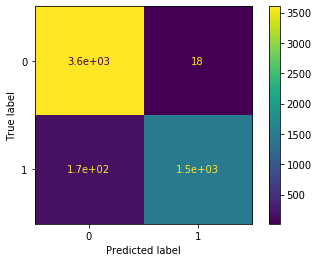

In [0]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(rfc, X_train, y_train)

In [0]:
from sklearn.model_selection import GridSearchCV

crfc = GridSearchCV(rfc, param_grid={'n_estimators': [1, 10, 100, 150, 200], 'min_samples_leaf':[ 1, 2, 4], 'max_depth':[ 4, 8, 16, 32]})
crfc.fit(X_train, y_train)

print(crfc.best_params_)
print(crfc.best_score_)


{'max_depth': 16, 'min_samples_leaf': 1, 'n_estimators': 100}
0.9179126285649902


In [0]:
rfc = RandomForestClassifier(max_depth=32, min_samples_leaf=1, n_estimators=100)

rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=32, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
#print(cross_val_score(rfc, X_train, y_train, cv=10))

cross_val = cross_val_score(rfc, X_train, y_train, cv=10) 

print("Results of cross_val_score")
print(cross_val)
print("The mean of cross_val_score ", cross_val.mean())
print("The  std of cross_val_score ", cross_val.std())

Results of cross_val_score
[0.90359168 0.9168242  0.9168242  0.9168242  0.89603025 0.92438563
 0.92816635 0.90909091 0.93181818 0.9280303 ]
The mean of cross_val_score  0.9171585896774932
The  std of cross_val_score  0.010965352665492428


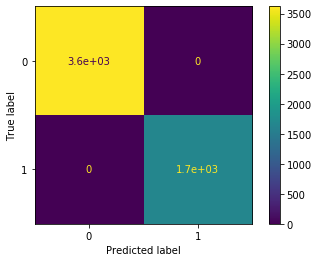

In [0]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(rfc, X_train, y_train)

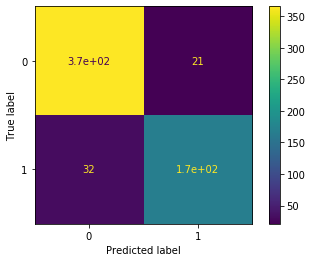

In [0]:
plot_confusion_matrix(rfc, X_test, y_test)

In [0]:
from sklearn.model_selection import GridSearchCV
import math
param_grid = {'max_depth': [4,8,16], 'max_features': [int(math.sqrt(len(X.columns))), int(math.log(len(X.columns)))]}
gs = GridSearchCV(rfc, param_grid=param_grid)
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)


0.9169676278227964
{'max_depth': 16, 'max_features': 4}


0.8996598639455783


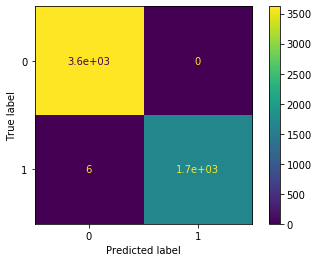

In [0]:
#X = dum_park.drop('diagnosis', axis=1)

X = dum_park[['Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]


y = dum_park['sex']

rf = RandomForestClassifier(max_depth=gs.best_params_['max_depth'], max_features=gs.best_params_['max_features'])
rf.fit(X_train, y_train)

print(rf.score(X_test, y_test))
plot_confusion_matrix(rf, X_train, y_train)

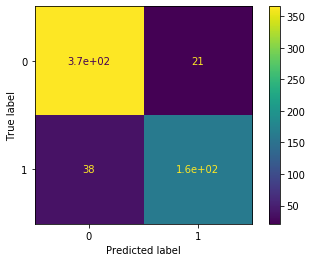

In [0]:
plot_confusion_matrix(rf, X_test, y_test)

In [0]:
park = parkinson.copy()
park.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [0]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()


X = park[['Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]


Y = park['sex']

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=.1)


In [0]:
from xgboost import XGBClassifier

xgb = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=500, verbosity=0)

xgb.fit(X_train, y_train)

# We are making predictions here
y_preds_train = xgb.predict(X_train)
y_preds_test = xgb.predict(X_test)

In [0]:
print("XGBClassifier model")
print("R-squared of the model in training set is: {}".format(xgb.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(xgb.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


XGBClassifier model
R-squared of the model in training set is: 1.0
-----Test set statistics-----
R-squared of the model in test set is: 0.9268707482993197
Mean absolute error of the prediction is: 0.07312925170068027
Mean squared error of the prediction is: 0.07312925170068027
Root mean squared error of the prediction is: 0.27042420694287017
Mean absolute percentage error of the prediction is: inf


In [0]:
xgb = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=500, verbosity=0)

cross_val = cross_val_score(xgb, X_train, y_train, cv=10) 

print("Results of cross_val_score")
print(cross_val)
print("The mean of cross_val_score ", cross_val.mean())
print("The  std of cross_val_score ", cross_val.std())

Results of cross_val_score
[0.9489603  0.92816635 0.95652174 0.92060491 0.93761815 0.93572779
 0.93383743 0.94128788 0.9375     0.94507576]
The mean of cross_val_score  0.93853003093315
The  std of cross_val_score  0.009713009799867821




---



---



---


KNN Classifier
---



---



---



In [0]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()


X = park[['Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]


Y = park['sex']

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=.1)

In [0]:
from sklearn.neighbors import KNeighborsClassifier
neighbors = KNeighborsClassifier(n_neighbors=15)
neighbors.fit(X_train,y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [0]:
y_preds_train = neighbors.predict(X_train)
y_preds_test = neighbors.predict(X_test)

In [0]:
print("KNN Classifier model")
print("R-squared of the model in training set is: {}".format(neighbors.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(neighbors.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
#print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


KNN Classifier model
R-squared of the model in training set is: 0.7620578778135049
-----Test set statistics-----
R-squared of the model in test set is: 0.7431972789115646
Mean absolute error of the prediction is: 0.2568027210884354
Mean squared error of the prediction is: 0.2568027210884354
Root mean squared error of the prediction is: 0.5067570631855419


In [0]:
knn = KNeighborsClassifier(n_neighbors=5)

cross_val = cross_val_score(knn, X_train, y_train, cv=10) 

print("Results of cross_val_score")
print(cross_val)
print("The mean of cross_val_score ", cross_val.mean())
print("The  std of cross_val_score ", cross_val.std())

Results of cross_val_score
[0.69943289 0.74858223 0.72589792 0.74669187 0.72022684 0.731569
 0.70321361 0.71969697 0.72348485 0.72159091]
The mean of cross_val_score  0.7240387094002406
The  std of cross_val_score  0.015015067746744184


# Classification based on subjectid



---



---



---
Classification based on Subject#


---



---



---



In [0]:
park = parkinson.copy()
park.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [0]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()


X = park[['Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]


Y = park['subject#']

#print(cross_val_score(rfc, X, Y, cv=10))

cross_val = cross_val_score(rfc, X, Y, cv=10) 

print("Results of cross_val_score")
print(cross_val)
print("The mean of cross_val_score ", cross_val.mean())
print("The  std of cross_val_score ", cross_val.std())


Results of cross_val_score
[0.51870748 0.5255102  0.63435374 0.58843537 0.57823129 0.60477002
 0.58603066 0.58432709 0.53833049 0.51107325]
The mean of cross_val_score  0.5669769611422082
The  std of cross_val_score  0.03900566442125529


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = park[['Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]

y = park['subject#']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.1)

rfc = RandomForestClassifier(max_depth=10)

rfc.fit(X_train, y_train)

y_preds_train = rfc.predict(X_train)
y_preds_test = rfc.predict(X_test)

In [0]:
print("RFC Classifier model")
print("R-squared of the model in training set is: {}".format(rfc.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(rfc.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


RFC Classifier model
R-squared of the model in training set is: 0.8214488367694345
-----Test set statistics-----
R-squared of the model in test set is: 0.5085034013605442
Mean absolute error of the prediction is: 7.006802721088436
Mean squared error of the prediction is: 149.8095238095238
Root mean squared error of the prediction is: 12.23967008581211
Mean absolute percentage error of the prediction is: 82.56903631868654


In [0]:
from sklearn.model_selection import GridSearchCV

crfc = GridSearchCV(rfc, param_grid={'n_estimators': [1, 10, 100, 150, 200], 'min_samples_leaf':[ 1, 2, 4], 'max_depth':[ 4, 8, 16, 32]})
crfc.fit(X_train, y_train)

print(crfc.best_params_)
print(crfc.best_score_)


{'max_depth': 32, 'min_samples_leaf': 1, 'n_estimators': 200}
0.5789672951768121


In [0]:
rfc = RandomForestClassifier(max_depth=32, min_samples_leaf=1, n_estimators=200)

rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=32, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
#print(cross_val_score(rfc, X_train, y_train, cv=10))

cross_val = cross_val_score(rfc, X_train, y_train, cv=10) 

print("Results of cross_val_score")
print(cross_val)
print("The mean of cross_val_score ", cross_val.mean())
print("The  std of cross_val_score ", cross_val.std())

Results of cross_val_score
[0.59357278 0.54442344 0.59357278 0.58601134 0.57088847 0.58034026
 0.59168242 0.57765152 0.60037879 0.59090909]
The mean of cross_val_score  0.5829430887323138
The  std of cross_val_score  0.01530713595600855


In [0]:
park = parkinson.copy()
park.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [0]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

X = park[['Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]


Y = park['subject#']

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=.1)


In [0]:
from xgboost import XGBClassifier

xgb = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=500, verbosity=0)

xgb.fit(X_train, y_train)

# We are making predictions here
y_preds_train = xgb.predict(X_train)
y_preds_test = xgb.predict(X_test)

In [0]:
print("XGBClassifier model")
print("R-squared of the model in training set is: {}".format(xgb.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(xgb.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


XGBClassifier model
R-squared of the model in training set is: 1.0
-----Test set statistics-----
R-squared of the model in test set is: 0.6173469387755102
Mean absolute error of the prediction is: 5.780612244897959
Mean squared error of the prediction is: 128.33843537414967
Root mean squared error of the prediction is: 11.328655497196022
Mean absolute percentage error of the prediction is: 90.06891280838926


In [0]:
xgb = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=500, verbosity=0)

cross_val = cross_val_score(xgb, X_train, y_train, cv=10) 

print("Results of cross_val_score")
print(cross_val)
print("The mean of cross_val_score ", cross_val.mean())
print("The  std of cross_val_score ", cross_val.std())

Results of cross_val_score
[0.61625709 0.60680529 0.58034026 0.61247637 0.62381853 0.62192817
 0.62759924 0.64204545 0.59469697 0.59659091]
The mean of cross_val_score  0.6122558286074355
The  std of cross_val_score  0.01722836555025933




---



---



---

KNN Classifier Based on subject#

---



---



---



In [0]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score


X = park[['Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
          'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 
          'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'Shimmer:APQ11', 'Shimmer:DDA']]


Y = park['subject#']

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=.1)

In [0]:
from sklearn.neighbors import KNeighborsClassifier
neighbors = KNeighborsClassifier(n_neighbors=15)
neighbors.fit(X_train,y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [0]:
y_preds_train = neighbors.predict(X_train)
y_preds_test = neighbors.predict(X_test)

In [0]:
print("KNN Classifier model")
print("R-squared of the model in training set is: {}".format(neighbors.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(neighbors.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
#print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


KNN Classifier model
R-squared of the model in training set is: 0.3729903536977492
-----Test set statistics-----
R-squared of the model in test set is: 0.23129251700680273
Mean absolute error of the prediction is: 11.091836734693878
Mean squared error of the prediction is: 243.57823129251702
Root mean squared error of the prediction is: 15.606993025324162


In [0]:
knn = KNeighborsClassifier(n_neighbors=5)

cross_val = cross_val_score(knn, X_train, y_train, cv=10) 

print("Results of cross_val_score")
print(cross_val)
print("The mean of cross_val_score ", cross_val.mean())
print("The  std of cross_val_score ", cross_val.std())

Results of cross_val_score
[0.2268431  0.268431   0.24952741 0.23251418 0.24574669 0.24385633
 0.21550095 0.2405303  0.20075758 0.23484848]
The mean of cross_val_score  0.23585560233717134
The  std of cross_val_score  0.017808316283914646




---



---



---

3D Graphs of Male vs Female voice quality data

---



---



---



# 3D Graphs Male VS Female

In [0]:
park = parkinson.copy()
park.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [0]:
park_F = park[park['sex']== 1]
park_M = park[park['sex']== 0]

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

column_names=["X","Y","Z"]
df = pd.DataFrame(columns = column_names)

df['X'] =  park_F['DFA']*100
df['Y'] =  park_F['Jitter(Abs)']*100000
df['Z'] =  park_F['Shimmer']*100


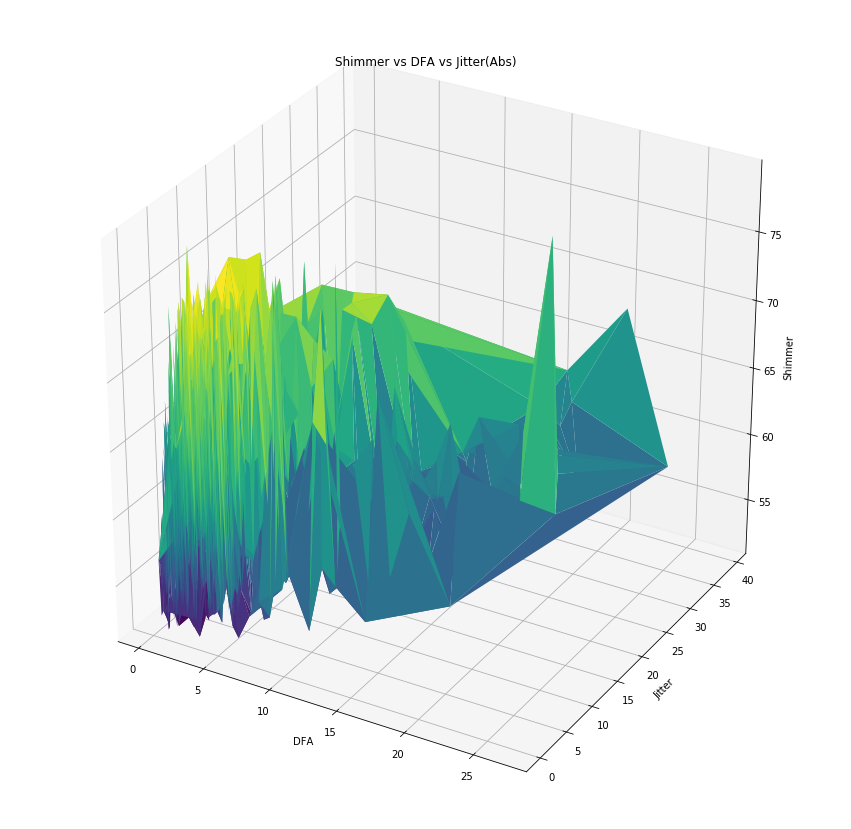

In [0]:
# Make the plot
fig = plt.figure(figsize=(15.0,15.0))
ax = fig.gca(projection='3d',ylabel='Jitter',xlabel='DFA', zlabel='Shimmer',title='Shimmer vs DFA vs Jitter(Abs)')

ax.plot_trisurf(df['Z'], df['Y'], df['X'], cmap=plt.cm.viridis, linewidth=0.2)
plt.show()
 
# to Add a color bar which maps values to colors.

surf=ax.plot_trisurf(df['Z'], df['Y'], df['X'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)
plt.show()
 
# Rotate it
ax.view_init(15,30)

plt.show()
 
# Other palette

ax.plot_trisurf(df['Z'], df['Y'], df['X'], cmap=plt.cm.jet, linewidth=0.01)

plt.show()


In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

column_names=["X","Y","Z"]
df = pd.DataFrame(columns = column_names)

df['X'] =  park_M['DFA']*100
df['Y'] =  park_M['Jitter(Abs)']*100000
df['Z'] =  park_M['Shimmer']*100


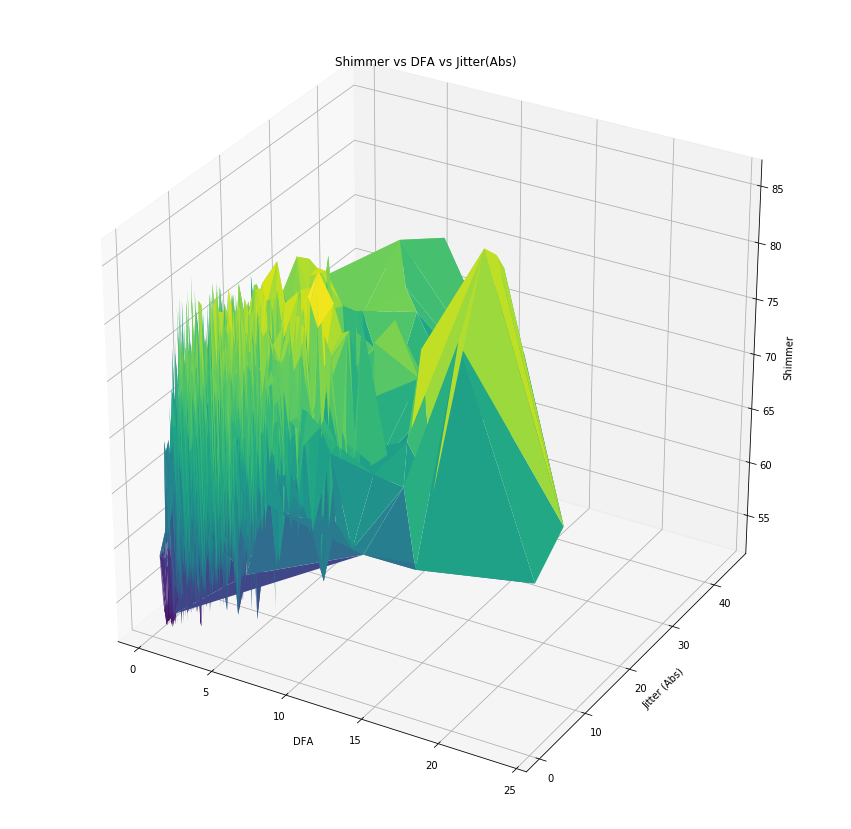

In [0]:
# Make the plot
fig = plt.figure(figsize=(15.0,15.0))
ax = fig.gca(projection='3d',zlabel='Shimmer',ylabel='Jitter (Abs)', xlabel='DFA',title='Shimmer vs DFA vs Jitter(Abs)')

ax.plot_trisurf(df['Z'], df['Y'], df['X'], cmap=plt.cm.viridis, linewidth=0.2)
plt.show()
 
# to Add a color bar which maps values to colors.

surf=ax.plot_trisurf(df['Z'], df['Y'], df['X'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)
plt.show()
 
# Rotate it
ax.view_init(15, 30)

plt.show()
 
# Other palette

ax.plot_trisurf(df['Z'], df['Y'], df['X'], cmap=plt.cm.jet, linewidth=0.01)

plt.show()




---



---



---


Experimental Graphs


---



---



---




# Experimental Graphs

In [0]:
park = parkinson.copy()
park.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
subject#         5875 non-null int64
age              5875 non-null int64
sex              5875 non-null int64
test_time        5875 non-null float64
motor_UPDRS      5875 non-null float64
total_UPDRS      5875 non-null float64
Jitter(%)        5875 non-null float64
Jitter(Abs)      5875 non-null float64
Jitter:RAP       5875 non-null float64
Jitter:PPQ5      5875 non-null float64
Jitter:DDP       5875 non-null float64
Shimmer          5875 non-null float64
Shimmer(dB)      5875 non-null float64
Shimmer:APQ3     5875 non-null float64
Shimmer:APQ5     5875 non-null float64
Shimmer:APQ11    5875 non-null float64
Shimmer:DDA      5875 non-null float64
NHR              5875 non-null float64
HNR              5875 non-null float64
RPDE             5875 non-null float64
DFA              5875 non-null float64
PPE              5875 non-null float64
dtypes: float64(19), int64(3)
memory usag

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

column_names=["X","Y","Z"]
df = pd.DataFrame(columns = column_names)

df['X'] =  park['test_time']*1
df['Y'] =  park['DFA']*1
df['Z'] =  park['total_UPDRS']*1
df['C'] =  park['subject#']
 

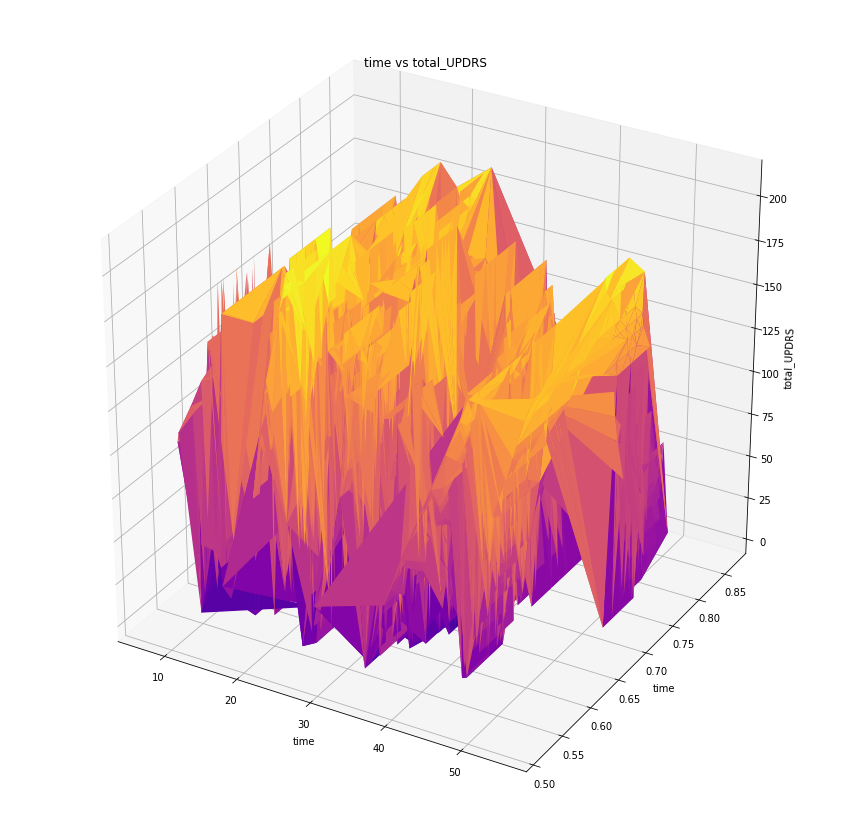

In [0]:
# Make the plot
fig = plt.figure(figsize=(15.0,15.0))
ax = fig.gca(projection='3d',zlabel='total_UPDRS',ylabel='time', xlabel='time',title='time vs total_UPDRS')


ax.plot_trisurf(df['Z'], df['Y'], df['X'], cmap=plt.cm.plasma, linewidth=0.2)

plt.show()
 
# to Add a color bar which maps values to colors.


surf=ax.plot_trisurf(df['Z'], df['Y'], df['X'], cmap=plt.cm.plasma, linewidth=0.2)

fig.colorbar( surf, shrink=0.5, aspect=5)

plt.show()
 
# Rotate it
ax.view_init(15, 30)

plt.show()
 
# Other palette


ax.plot_trisurf(df['Z'], df['Y'], df['X'], cmap=plt.cm.jet, linewidth=0.01)

plt.show()


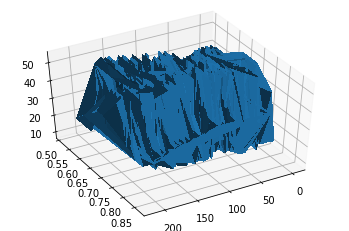

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


column_names=["X","Y","Z"]
df = pd.DataFrame(columns = column_names)

X =  park['test_time']*1
Y =  park['DFA']*1
Z =  park['total_UPDRS']*1
V =  park['subject#']


# create the figure, add a 3d axis, set the viewing angle
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45,60)

# here we create the surface plot, but pass V through a colormap
# to create a different color for each patch

#ax.plot_surface(X, Y, Z, facecolors=cm.Oranges(V))

surf = ax.plot_trisurf(X, Y, Z, linewidth=0, antialiased=False)

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

column_names=["X","Y","Z"]
df = pd.DataFrame(columns = column_names)

df['X'] =  park['test_time']*1
df['Y'] =  park['subject#']*1
df['Z'] =  park['total_UPDRS']*1


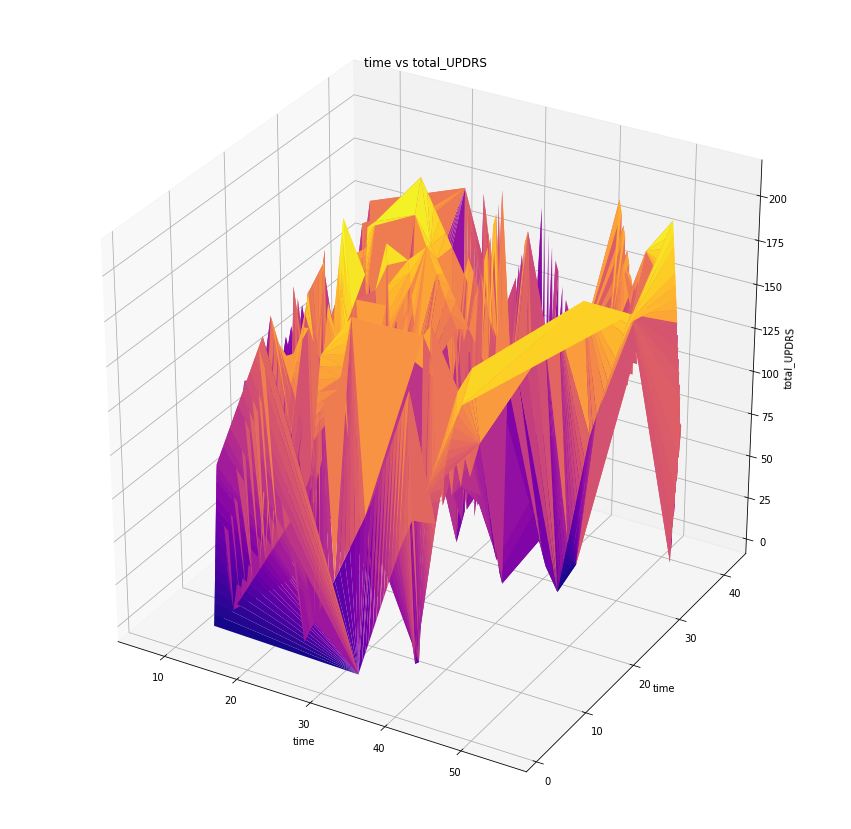

In [0]:
# Make the plot
fig = plt.figure(figsize=(15.0,15.0))
ax = fig.gca(projection='3d',zlabel='total_UPDRS',ylabel='time', xlabel='time',title='time vs total_UPDRS')

#ax.plot_trisurf(df['Z'], df['Y'], df['X'], cmap=plt.cm.viridis, linewidth=0.2)

ax.plot_trisurf(df['Z'], df['Y'], df['X'], cmap=plt.cm.plasma, linewidth=0.2)

plt.show()
 
# to Add a color bar which maps values to colors.

#surf=ax.plot_trisurf(df['Z'], df['Y'], df['X'], cmap=plt.cm.viridis, linewidth=0.2)

surf=ax.plot_trisurf(df['Z'], df['Y'], df['X'], cmap=plt.cm.plasma, linewidth=0.2)

fig.colorbar( surf, shrink=0.5, aspect=5)

plt.show()
 
# Rotate it
ax.view_init(15, 30)

plt.show()
 
# Other palette

ax.plot_trisurf(df['Z'], df['Y'], df['X'], cmap=plt.cm.jet, linewidth=0.01)

plt.show()
